# Step 1: Import the Necessary Libraries

In [192]:
# General-Purpose Libraries
import numpy as np
import pandas as pd
import os
import warnings
from scipy.spatial import distance
from scipy.stats import zscore

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Data Preprocessing & Feature Engineering
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

# Model Selection & Evaluation
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve
)

# Anomaly Detection Models
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import hdbscan

# Dimensionality Reduction for Visualization
from sklearn.manifold import TSNE
import umap
from umap.umap_ import UMAP

# Deep Learning
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Explainability
import shap

# Utility
from datetime import datetime
from functools import reduce

# Step 2: Load the Dataset

In [4]:
# Load the Dataset
df = pd.read_json("steambans.json", lines=True)

# Step 3: Exploratory Data Analysis

In [6]:
# Preview the first few rows
df.head()

steam_id                                        profile_url  \
0  76561197960265760  https://steamcommunity.com/profiles/7656119796...   
1  76561197960266640  https://steamcommunity.com/id/765611979602666420/   
2  76561197960267168              https://steamcommunity.com/id/c0R716/   
3  76561197960267328             https://steamcommunity.com/id/3digits/   
4  76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   

  personaname                                             avatar  timecreated  \
0      Gordon  https://avatars.steamstatic.com/1eefc24823028f...            0   
1       Goose  https://avatars.steamstatic.com/5fb7d7eabf3add...   1063271354   
2         c0R  https://avatars.steamstatic.com/9af72ff4737cf3...            0   
3       Fanik  https://avatars.steamstatic.com/8d43de6e684bc6...   1063285951   
4  ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   1063288640   

   communityvisibilitystate  vac_bans  game_bans economy_ban  last_ban  \
0                         1         1          0        none    3401.0   
1                         3         1          1        none     183.0   
2                         2         2          0        none    3335.0   
3                         3         1          0        none    4639.0   
4                         3         0          0        none       NaN   

   steam_level  friends_count  game_count  total_playtime  cs2_playtime  
0           -1             -1          -1              -1            -1  
1           -1             -1          -1              -1            -1  
2           -1             -1          -1              -1            -1  
3           11              3          -1               0             0  
4           13            192          64          205421         91643

In [7]:
# Number of rows and columns
print("Dataset Shape:", df.shape)

Dataset Shape: (476694, 15)


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476694 entries, 0 to 476693
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   steam_id                  476694 non-null  int64  
 1   profile_url               476694 non-null  object 
 2   personaname               476694 non-null  object 
 3   avatar                    476694 non-null  object 
 4   timecreated               476694 non-null  int64  
 5   communityvisibilitystate  476694 non-null  int64  
 6   vac_bans                  476694 non-null  int64  
 7   game_bans                 476694 non-null  int64  
 8   economy_ban               476694 non-null  object 
 9   last_ban                  253546 non-null  float64
 10  steam_level               476694 non-null  int64  
 11  friends_count             476694 non-null  int64  
 12  game_count                476694 non-null  int64  
 13  total_playtime            476694 non-null  i

In [9]:
# Check for null/missing values
missing = df.isnull().sum()
print("Missing Values:")
print(missing[missing > 0])

Missing Values:
last_ban    223148
dtype: int64


In [10]:
# Check for duplicated rows
duplicates = df.duplicated().sum()
print("Duplicate Rows:", duplicates)

Duplicate Rows: 0


In [11]:
# Columns with only one unique value (not useful for modeling)
low_var_cols = [col for col in df.columns if df[col].nunique() == 1]
print("Low-Variance (Constant) Columns:", low_var_cols)

Low-Variance (Constant) Columns: []


In [12]:
# Summary statistics
df.describe(include='all')

steam_id                              profile_url personaname  \
count   4.766940e+05                                   476694      476694   
unique           NaN                                   476178      399689   
top              NaN  https://steamcommunity.com/id/evoTermi/               
freq             NaN                                        3         930   
mean    7.656120e+16                                      NaN         NaN   
std     4.422518e+08                                      NaN         NaN   
min     7.656120e+16                                      NaN         NaN   
25%     7.656120e+16                                      NaN         NaN   
50%     7.656120e+16                                      NaN         NaN   
75%     7.656120e+16                                      NaN         NaN   
max     7.656120e+16                                      NaN         NaN   

                                                   avatar   timecreated  \
count                                              476694  4.766940e+05   
unique                                             366005           NaN   
top     https://avatars.steamstatic.com/fef49e7fa7e199...           NaN   
freq                                                23771           NaN   
mean                                                  NaN  1.388416e+09   
std                                                   NaN  4.095722e+08   
min                                                   NaN  0.000000e+00   
25%                                                   NaN  1.411679e+09   
50%                                                   NaN  1.499094e+09   
75%                                                   NaN  1.587674e+09   
max                                                   NaN  1.704822e+09   

        communityvisibilitystate       vac_bans      game_bans economy_ban  \
count              476694.000000  476694.000000  476694.000000      476694   
unique                       NaN            NaN            NaN           2   
top                          NaN            NaN            NaN        none   
freq                         NaN            NaN            NaN      476380   
mean                    2.873132       0.423299       0.187221         NaN   
std                     0.464050       0.590747       0.472401         NaN   
min                     1.000000       0.000000       0.000000         NaN   
25%                     3.000000       0.000000       0.000000         NaN   
50%                     3.000000       0.000000       0.000000         NaN   
75%                     3.000000       1.000000       0.000000         NaN   
max                     3.000000      53.000000      34.000000         NaN   

             last_ban    steam_level  friends_count     game_count  \
count   253546.000000  476694.000000  476694.000000  476694.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean      1498.595576      12.591165      49.055375      20.841322   
std        936.215363      22.649761      71.076959      97.783688   
min          1.000000      -1.000000      -1.000000      -1.000000   
25%        986.000000       0.000000       3.000000      -1.000000   
50%       1301.000000       7.000000      25.000000      -1.000000   
75%       1822.000000      14.000000      65.000000      -1.000000   
max       7422.000000    2473.000000    2000.000000   20274.000000   

        total_playtime  cs2_playtime  
count     4.766940e+05  4.766940e+05  
unique             NaN           NaN  
top                NaN           NaN  
freq               NaN           NaN  
mean      4.899878e+04  1.846007e+04  
std       2.457081e+05  5.786980e+04  
min      -1.000000e+00 -1.000000e+00  
25%       0.000000e+00  0.000000e+00  
50%       0.000000e+00  0.000000e+00  
75%       0.000000

In [13]:
# Loop through each column to count unique values
for col in df.columns:
    unique_count = df[col].nunique()
    if unique_count <= 10:
        print(f"\nColumn: {col}")
        print(f"Unique count: {unique_count}")
        print(f"Unique values: {df[col].unique()}")


Column: communityvisibilitystate
Unique count: 3
Unique values: [1 3 2]

Column: economy_ban
Unique count: 2
Unique values: ['none' 'banned']


In [14]:
# List of placeholder values to check
placeholders = [0, -1, None, np.nan, ""]

print("Suspicious values found in the following columns:\n")

for col in df.columns:
    col_reported = False  # To avoid multiple prints for the same column
    for val in placeholders:
        if val is None or (isinstance(val, float) and np.isnan(val)):
            # Check for NaN or None
            if df[col].isnull().any():
                print(f"Column '{col}' contains NaN or None")
                col_reported = True
        else:
            # Check for specific values like 0, -1, ''
            if (df[col] == val).any():
                print(f"Column '{col}' contains the value: {repr(val)}")
                col_reported = True
    if col_reported:
        print("-" * 50)

Suspicious values found in the following columns:

Column 'personaname' contains the value: ''
--------------------------------------------------
Column 'timecreated' contains the value: 0
--------------------------------------------------
Column 'vac_bans' contains the value: 0
--------------------------------------------------
Column 'game_bans' contains the value: 0
--------------------------------------------------
Column 'last_ban' contains NaN or None
Column 'last_ban' contains NaN or None
--------------------------------------------------
Column 'steam_level' contains the value: 0
Column 'steam_level' contains the value: -1
--------------------------------------------------
Column 'friends_count' contains the value: 0
Column 'friends_count' contains the value: -1
--------------------------------------------------
Column 'game_count' contains the value: -1
--------------------------------------------------
Column 'total_playtime' contains the value: 0
Column 'total_playtime' cont

In [15]:
# Filter rows where last_ban is null (NaN or None)
missing_last_ban = df[df['last_ban'].isnull()]

# Check how many of them have vac_bans and game_bans as 0 or -1, and economy_ban as 'none'
valid_rows = missing_last_ban[
    (missing_last_ban['vac_bans'].isin([0, -1])) &
    (missing_last_ban['game_bans'].isin([0, -1])) &
    (missing_last_ban['economy_ban'] == 'none')
]

# Print counts
print(f"Total rows where 'last_ban' is missing: {len(missing_last_ban)}")
print(f"Rows where vac_bans & game_bans are 0/-1 and economy_ban is 'none': {len(valid_rows)}")

# If needed, view a sample
valid_rows.head()

Total rows where 'last_ban' is missing: 223148
Rows where vac_bans & game_bans are 0/-1 and economy_ban is 'none': 223148


steam_id                                        profile_url  \
4   76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   
6   76561197960268560           https://steamcommunity.com/id/Zeuslol17/   
7   76561197960268560           https://steamcommunity.com/id/Zeuslol17/   
8   76561197960269376  https://steamcommunity.com/profiles/7656119796...   
12  76561197960269664         https://steamcommunity.com/id/jessedotnet/   

    personaname                                             avatar  \
4    ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   
6       Zeuslol  https://avatars.steamstatic.com/feb6e7b46851a8...   
7       Zeuslol  https://avatars.steamstatic.com/feb6e7b46851a8...   
8      mrkorney  https://avatars.steamstatic.com/f98119d99303dd...   
12  axe grinder  https://avatars.steamstatic.com/fef49e7fa7e199...   

    timecreated  communityvisibilitystate  vac_bans  game_bans economy_ban  \
4    1063288640                         3         0          0        none   
6    1063314713                         3         0          0        none   
7    1063314713                         3         0          0        none   
8    1063346724                         3         0          0        none   
12   1063347997                         3         0          0        none   

    last_ban  steam_level  friends_count  game_count  total_playtime  \
4        NaN           13            192          64          205421   
6        NaN           28             83         391          746025   
7        NaN           28             83         391          746176   
8        NaN           11             88          -1               0   
12       NaN           11             42          -1               0   

    cs2_playtime  
4          91643  
6         156459  
7         156548  
8              0  
12             0

In [16]:
# Rows with values -1
cols_with_neg1 = ['steam_level', 'friends_count', 'game_count', 'total_playtime', 'cs2_playtime']

for col in cols_with_neg1:
    count = (df[col] == -1).sum()
    print(f"Column '{col}' has {count} rows with -1 values.")

Column 'steam_level' has 59470 rows with -1 values.
Column 'friends_count' has 59006 rows with -1 values.
Column 'game_count' has 366243 rows with -1 values.
Column 'total_playtime' has 59006 rows with -1 values.
Column 'cs2_playtime' has 59006 rows with -1 values.


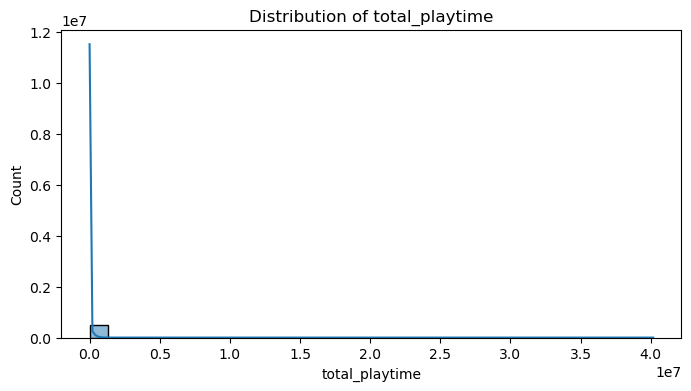

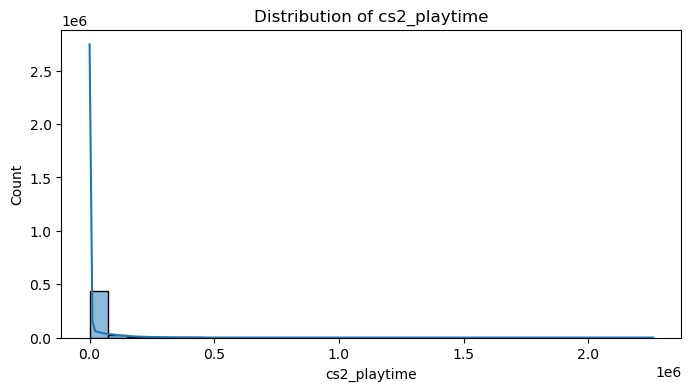

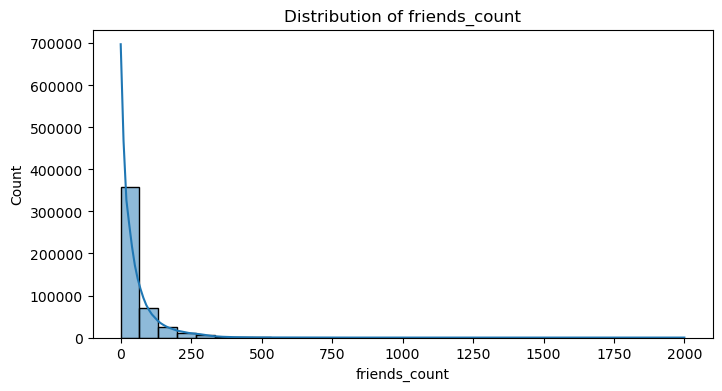

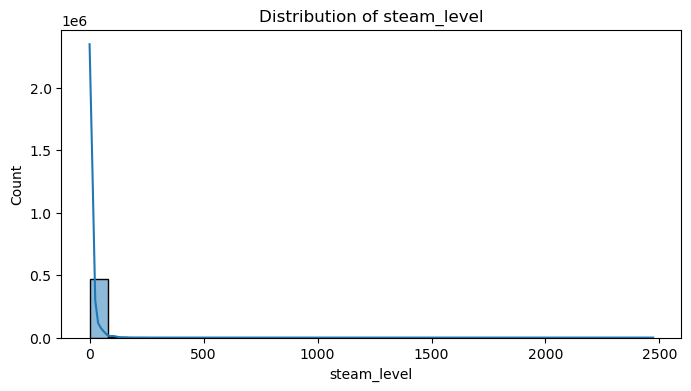

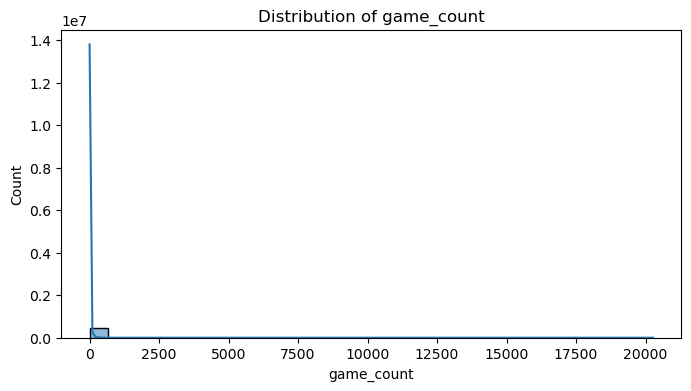

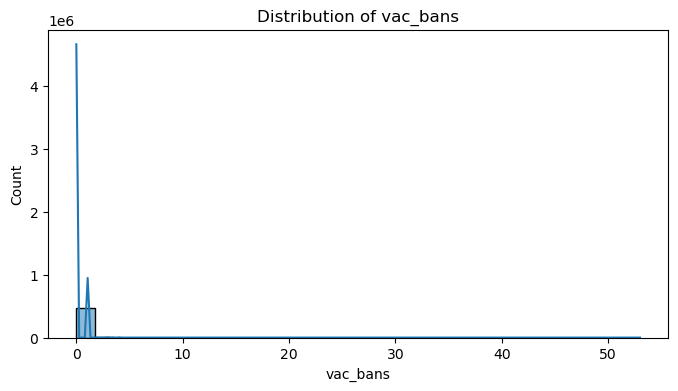

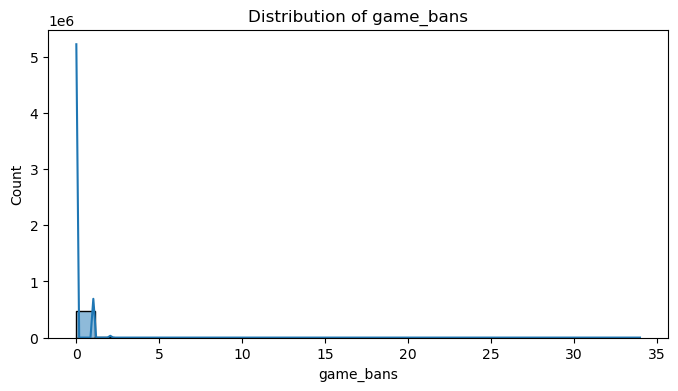

In [17]:
# To check skewness, modality
num_cols = ['total_playtime', 'cs2_playtime', 'friends_count', 'steam_level', 'game_count', 'vac_bans', 'game_bans']

for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

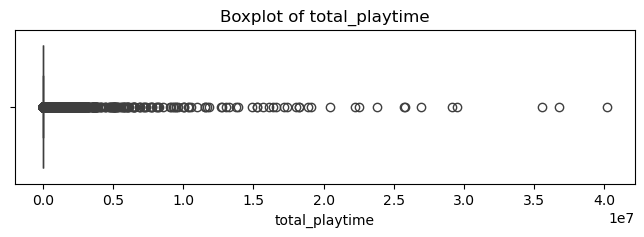

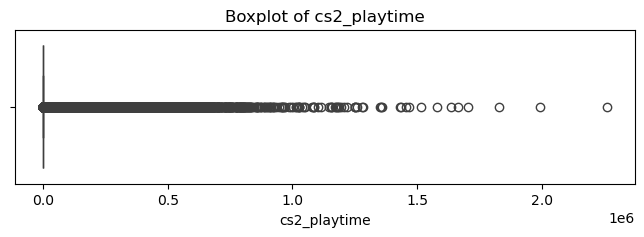

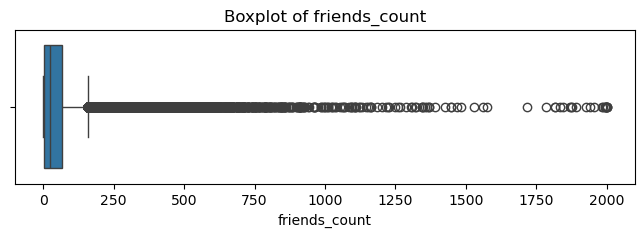

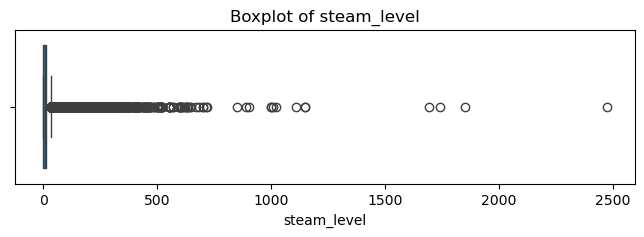

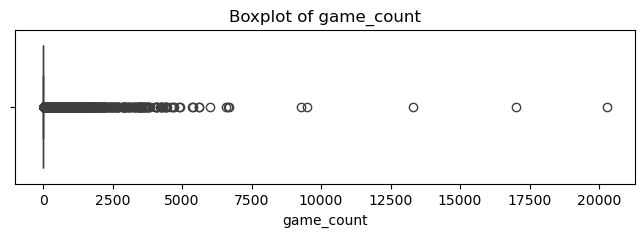

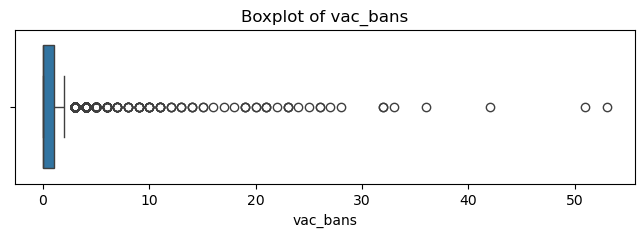

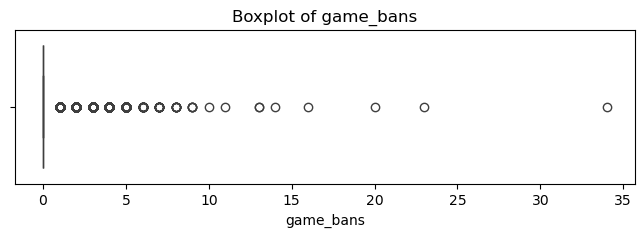

In [18]:
# To check outliers
for col in num_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

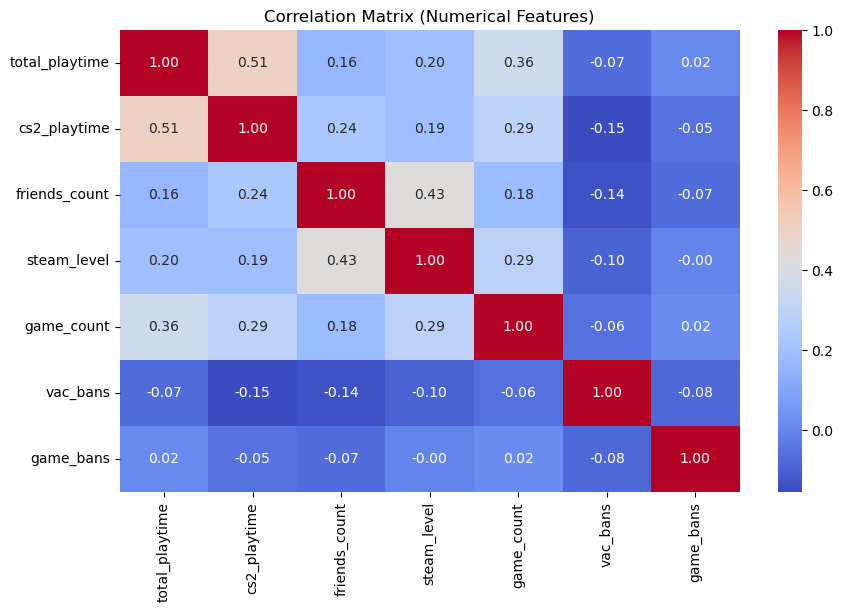

In [19]:
# To identify relationships between numerical variables:
plt.figure(figsize=(10, 6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

In [20]:
# Value Counts / Frequency Tables
cat_cols = ['economy_ban', 'communityvisibilitystate']

for col in cat_cols:
    print(f"\nValue counts for {col}:")
    print(df[col].value_counts())


Value counts for economy_ban:
economy_ban
none      476380
banned       314
Name: count, dtype: int64

Value counts for communityvisibilitystate:
communityvisibilitystate
3    441141
1     24924
2     10629
Name: count, dtype: int64


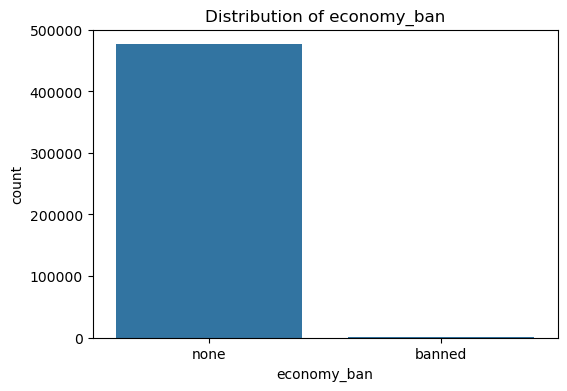

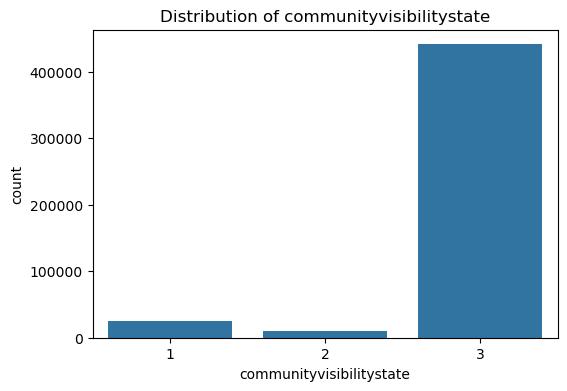

In [21]:
# Bar Plots for Frequency
for col in cat_cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=df, x=col)
    plt.title(f"Distribution of {col}")
    plt.show()

In [22]:
# How each category affects numerical stats
for col in cat_cols:
    for num in num_cols:
        grouped = df.groupby(col)[num].mean()
        print(f"\nAverage {num} per {col}:\n{grouped}")


Average total_playtime per economy_ban:
economy_ban
banned    27813.063694
none      49012.744958
Name: total_playtime, dtype: float64

Average cs2_playtime per economy_ban:
economy_ban
banned    15396.229299
none      18462.087178
Name: cs2_playtime, dtype: float64

Average friends_count per economy_ban:
economy_ban
banned    48.535032
none      49.055718
Name: friends_count, dtype: float64

Average steam_level per economy_ban:
economy_ban
banned    18.748408
none      12.587107
Name: steam_level, dtype: float64

Average game_count per economy_ban:
economy_ban
banned    12.471338
none      20.846839
Name: game_count, dtype: float64

Average vac_bans per economy_ban:
economy_ban
banned    0.821656
none      0.423036
Name: vac_bans, dtype: float64

Average game_bans per economy_ban:
economy_ban
banned    0.394904
none      0.187084
Name: game_bans, dtype: float64

Average total_playtime per communityvisibilitystate:
communityvisibilitystate
1       -1.000000
2       -1.000000
3    5294

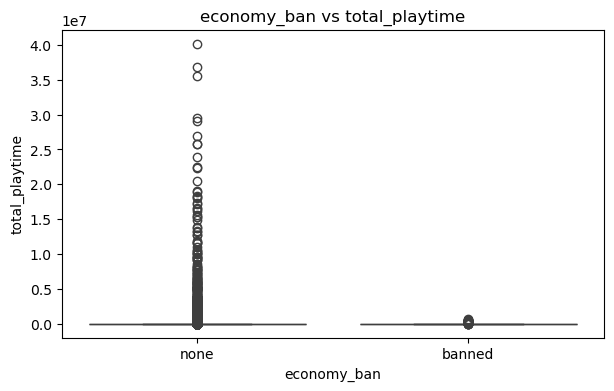

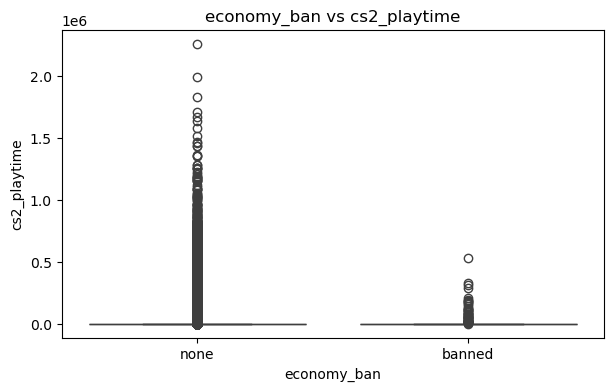

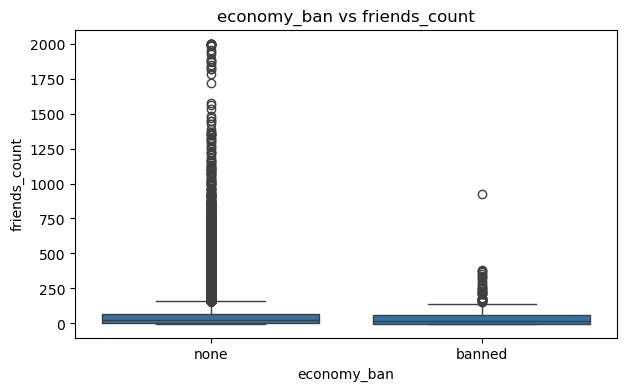

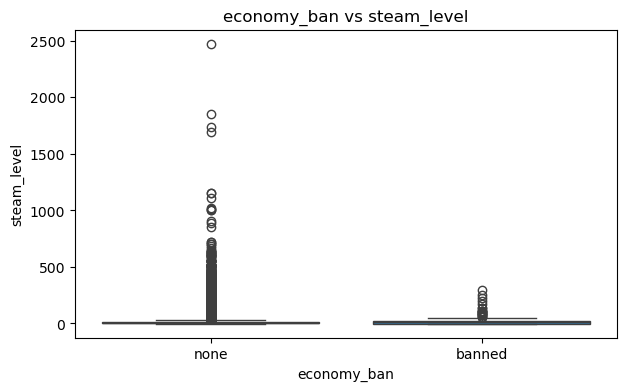

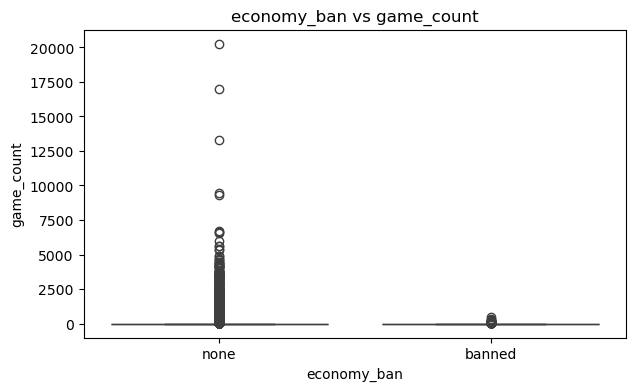

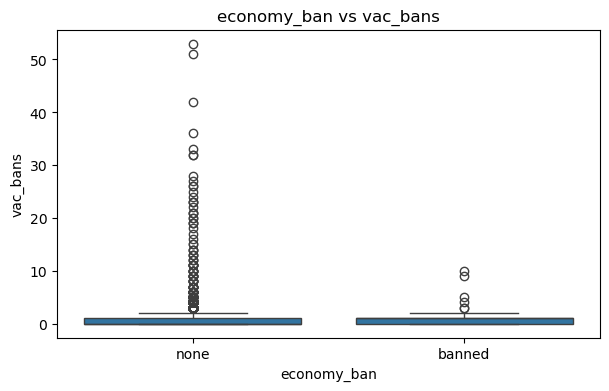

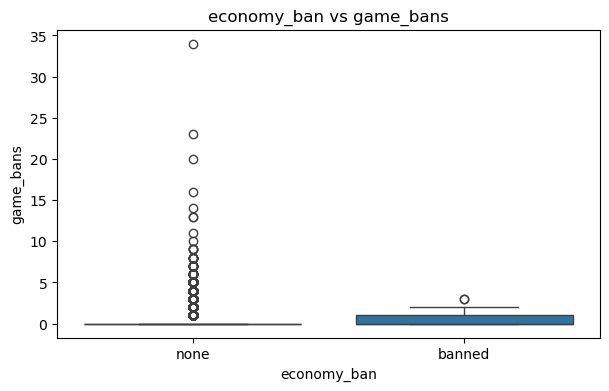

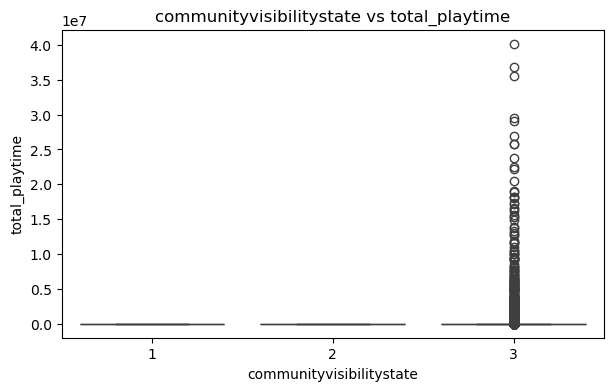

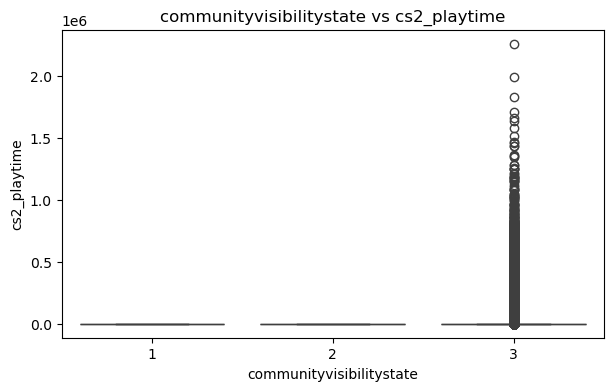

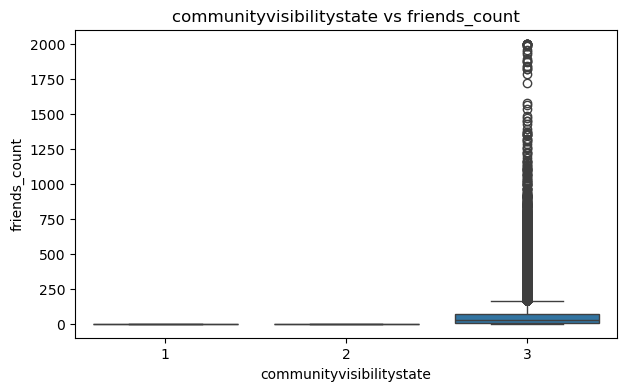

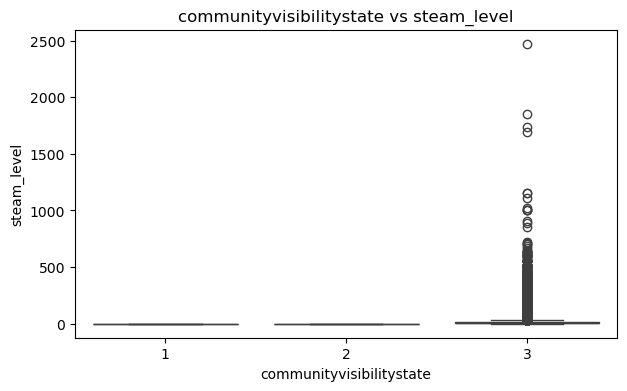

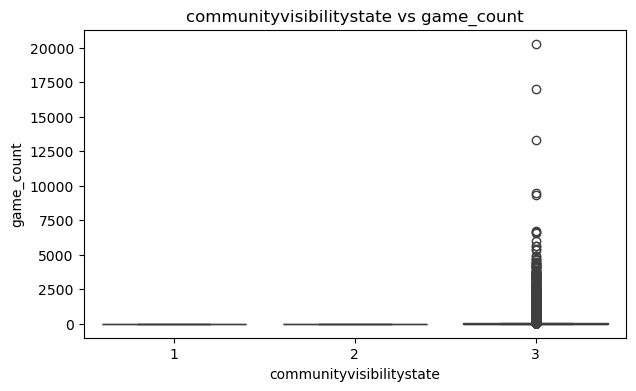

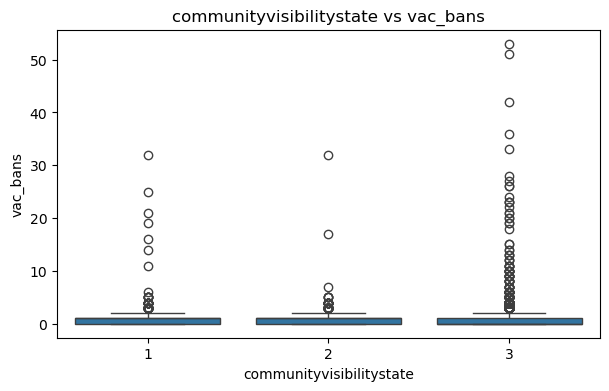

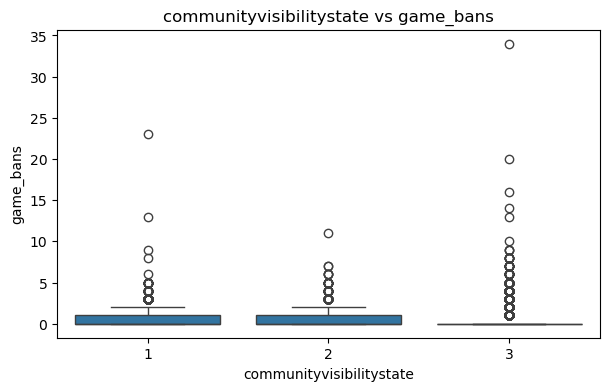

In [23]:
# boxplots for visualizing interactions
for col in cat_cols:
    for num in num_cols:
        plt.figure(figsize=(7, 4))
        sns.boxplot(data=df, x=col, y=num)
        plt.title(f"{col} vs {num}")
        plt.show()

In [24]:
# Handling Rare Categories
for col in cat_cols:
    rare = df[col].value_counts()[df[col].value_counts(normalize=True) < 0.01]
    print(f"\nRare categories in {col}:\n{rare}")


Rare categories in economy_ban:
economy_ban
banned    314
Name: count, dtype: int64

Rare categories in communityvisibilitystate:
Series([], Name: count, dtype: int64)


In [25]:
# List of columns to check
columns_to_check = ['steam_id', 'profile_url', 'personaname']

# Dictionary to store duplicates
duplicate_values = {}

# Loop through each column and get values that appear more than once
for col in columns_to_check:
    duplicates = df[col].value_counts()
    duplicates = duplicates[duplicates > 1]
    duplicate_values[col] = duplicates

# Display the results
for col, values in duplicate_values.items():
    print(f"Duplicate values in column '{col}':")
    print(values)
    print('-' * 60)

Duplicate values in column 'steam_id':
steam_id
76561199001176640    3
76561198036541712    3
76561198125110688    3
76561198347990496    3
76561198366580496    3
                    ..
76561198180875552    2
76561199066719376    2
76561198056404992    2
76561198034527312    2
76561199071459328    2
Name: count, Length: 2770, dtype: int64
------------------------------------------------------------
Duplicate values in column 'profile_url':
profile_url
https://steamcommunity.com/id/evoTermi/                   3
https://steamcommunity.com/profiles/76561197963055450/    3
https://steamcommunity.com/id/luxione_lux/                2
https://steamcommunity.com/profiles/76561199091323506/    2
https://steamcommunity.com/profiles/76561198035220028/    2
                                                         ..
https://steamcommunity.com/id/Dannnnnjj/                  2
https://steamcommunity.com/id/trosky1212/                 2
https://steamcommunity.com/id/Glagol_SpirinS/             2
http

In [26]:
# 1. Duplicate (steam_id, profile_url) pairs
pair1 = df.duplicated(subset=['steam_id', 'profile_url'], keep=False)
count_pair1 = df[pair1][['steam_id', 'profile_url']].drop_duplicates().shape[0]
print(f"(steam_id, profile_url) duplicate pairs: {count_pair1}")

# 2. Duplicate (steam_id, personaname) pairs
pair2 = df.duplicated(subset=['steam_id', 'personaname'], keep=False)
count_pair2 = df[pair2][['steam_id', 'personaname']].drop_duplicates().shape[0]
print(f"(steam_id, personaname) duplicate pairs: {count_pair2}")

# 3. Duplicate (profile_url, personaname) pairs
pair3 = df.duplicated(subset=['profile_url', 'personaname'], keep=False)
count_pair3 = df[pair3][['profile_url', 'personaname']].drop_duplicates().shape[0]
print(f"(profile_url, personaname) duplicate pairs: {count_pair3}")

# 4. Duplicate triplets (steam_id, profile_url, personaname)
triplet = df.duplicated(subset=['steam_id', 'profile_url', 'personaname'], keep=False)
count_triplet = df[triplet][['steam_id', 'profile_url', 'personaname']].drop_duplicates().shape[0]
print(f"(steam_id, profile_url, personaname) duplicate triplets: {count_triplet}")

(steam_id, profile_url) duplicate pairs: 513
(steam_id, personaname) duplicate pairs: 446
(profile_url, personaname) duplicate pairs: 445
(steam_id, profile_url, personaname) duplicate triplets: 445


# Step 4: Feature Engineering

In [28]:
# Feature 1: Create account_age_days from timecreated
df['account_age_days'] = (pd.to_datetime('today') - pd.to_datetime(df['timecreated'], unit='s')).dt.days

# Feature 2: Extract account_year from timecreated
df['account_year'] = pd.to_datetime(df['timecreated'], unit='s').dt.year

# Drop the timecreated column (since it's now redundant)
df = df.drop(columns=['timecreated'])

# Verify the changes
df[['steam_id', 'account_age_days', 'account_year']].head()

steam_id  account_age_days  account_year
0  76561197960265760             20207          1970
1  76561197960266640              7901          2003
2  76561197960267168             20207          1970
3  76561197960267328              7901          2003
4  76561197960267408              7901          2003

# Step 5: Data Preprocessing

In [30]:
# Copy to preserve original
df_preprocessed = df.copy()

In [31]:
# Step 1: Identify rows where account_age_days = 20196 or account_year = 1970
mask_invalid_age = (df_preprocessed['account_age_days'] == 20196) | (df_preprocessed['account_year'] == 1970)

# Step 2: Count these rows
num_invalid = mask_invalid_age.sum()
print(f"Number of rows with invalid account age or year (likely UNIX timestamp = 0): {num_invalid}")

Number of rows with invalid account age or year (likely UNIX timestamp = 0): 35553


In [32]:
# Calculate median values only from valid rows
valid_mask = (df_preprocessed['account_age_days'] != 20196) & (df_preprocessed['account_year'] != 1970)

median_age_days = df_preprocessed.loc[valid_mask, 'account_age_days'].median()
median_account_year = df_preprocessed.loc[valid_mask, 'account_year'].median()

# Impute
df_preprocessed.loc[mask_invalid_age, 'account_age_days'] = median_age_days
df_preprocessed.loc[mask_invalid_age, 'account_year'] = median_account_year

print(f"Imputed account_age_days with: {median_age_days}")
print(f"Imputed account_year with: {median_account_year}")

Imputed account_age_days with: 2602.0
Imputed account_year with: 2018.0


In [33]:
# Encode 'economy_ban'
df_preprocessed['economy_ban'] = df_preprocessed['economy_ban'].map({'none': 0, 'banned': 1})

In [34]:
# Replace -1 with NaN in relevant columns
cols_with_minus1 = ['steam_level', 'friends_count', 'game_count', 'total_playtime', 'cs2_playtime']
for col in cols_with_minus1:
    if col == 'game_count':
        df_preprocessed[f'{col}_missing'] = (df_preprocessed[col] == -1).astype(int)
    df_preprocessed[col] = df_preprocessed[col].replace(-1, np.nan)
    median_val = df_preprocessed[col].median()
    df_preprocessed[col] = df_preprocessed[col].fillna(median_val)

In [35]:
# Fill missing values in 'last_ban' with 0
df_preprocessed['last_ban'] = df_preprocessed['last_ban'].fillna(0)

In [36]:
# Log-Transformations
cols_to_log_and_scale = ['total_playtime', 'cs2_playtime', 'friends_count', 'game_count', 'steam_level']
for col in cols_to_log_and_scale:
    df_preprocessed[col] = np.log1p(df_preprocessed[col])

# Now scale
scaler = MinMaxScaler()
df_preprocessed[cols_to_log_and_scale] = scaler.fit_transform(df_preprocessed[cols_to_log_and_scale])

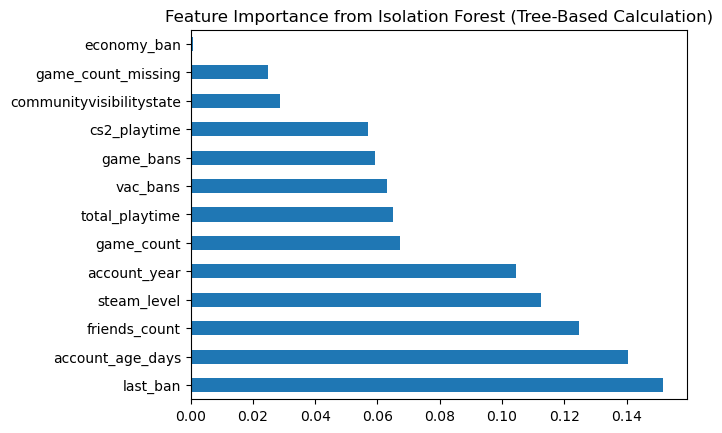

In [37]:
# Model-Based Feature Importance
# Exclude non-numeric or identifier columns
columns_to_exclude = ['steam_id', 'profile_url', 'personaname', 'avatar']
X = df_preprocessed.drop(columns=columns_to_exclude)

# Fit Isolation Forest
iso = IsolationForest(random_state=42)
iso.fit(X)

# Calculate feature importance using tree-based averaging
import numpy as np
feature_importances = np.mean([
    tree.feature_importances_ 
    for tree in iso.estimators_  # Access individual trees
], axis=0)

# Create and plot importances
importances = pd.Series(feature_importances, index=X.columns)
importances.sort_values(ascending=False).plot(kind='barh')
plt.title("Feature Importance from Isolation Forest (Tree-Based Calculation)")
plt.show()

# Step 6: Splitting the Dataset (Might be Unrequired)

# Step 7: Implement Anomaly Detection Methods

## A) Data-Driven Rule-Based Anomaly Detection

In [41]:
# Extract necessary columns (already scaled or cleaned)
df_temp = df_preprocessed.copy()

In [42]:
# Columns to be Used on Training
columns_to_exclude = ['steam_id', 'profile_url', 'personaname', 'avatar'] 
columns_to_use = df_preprocessed.drop(columns=columns_to_exclude).columns

In [43]:
# Rule 1: vac_bans > data-driven threshold AND total_playtime < Q1
vac_bans_threshold = df_temp['vac_bans'].quantile(0.95)  # Top 5% VAC bans
playtime_threshold = df_temp['total_playtime'].quantile(0.25)
rule_1 = (df_temp['vac_bans'] > vac_bans_threshold) & (df_temp['total_playtime'] < playtime_threshold)

In [44]:
# Rule 2: account_age_days < Q1 AND game_count > Q3
account_age_threshold = df_temp['account_age_days'].quantile(0.25)
game_count_threshold = df_temp['game_count'].quantile(0.75)
rule_2 = (df_temp['account_age_days'] < account_age_threshold) & (df_temp['game_count'] > game_count_threshold)

In [45]:
# Rule 3: friends_count > mean + 3*std
friends_mean = df_temp['friends_count'].mean()
friends_std = df_temp['friends_count'].std()
friends_threshold = friends_mean + 3 * friends_std
rule_3 = df_temp['friends_count'] > friends_threshold

In [46]:
# Rule 4: playtime_per_day > 95th percentile
playtime_per_day = df_temp['total_playtime'] / (df_temp['account_age_days'] + 1)
rate_threshold = playtime_per_day.quantile(0.95)
rule_4 = playtime_per_day > rate_threshold

In [47]:
# Rule 5: cs2_playtime very high compared to total_playtime (possible single-game spammer)
cs2_ratio = df_temp['cs2_playtime'] / (df_temp['total_playtime'] + 1e-3)
cs2_ratio_threshold = cs2_ratio.quantile(0.99)
rule_5 = cs2_ratio > cs2_ratio_threshold

In [48]:
# Rule 6: steam_level is extremely high (top 1%)
steam_level_threshold = df_temp['steam_level'].quantile(0.99)
rule_6 = df_temp['steam_level'] > steam_level_threshold

In [49]:
# Rule 7: game_count is extremely low while account is old (possible inactive/burner account)
game_count_threshold_low = df_temp['game_count'].quantile(0.10)
account_age_threshold_high = df_temp['account_age_days'].quantile(0.75)
rule_7 = (df_temp['game_count'] < game_count_threshold_low) & (df_temp['account_age_days'] > account_age_threshold_high)

In [50]:
# Rule 8: friends_count is very low while game_count is very high (possible reseller / solo spammer)
friends_threshold_low = df_temp['friends_count'].quantile(0.10)
game_count_threshold_high = df_temp['game_count'].quantile(0.90)
rule_8 = (df_temp['friends_count'] < friends_threshold_low) & (df_temp['game_count'] > game_count_threshold_high)

In [51]:
# Rule 9: account is very new and already has very high cs2_playtime (possible boosted or fake)
account_age_threshold_new = df_temp['account_age_days'].quantile(0.10)
cs2_playtime_threshold_high = df_temp['cs2_playtime'].quantile(0.90)
rule_9 = (df_temp['account_age_days'] < account_age_threshold_new) & (df_temp['cs2_playtime'] > cs2_playtime_threshold_high)

In [52]:
# Rule 10: cs2_playtime is non-zero but total_playtime is extremely low (possibly fake data)
playtime_threshold_low = df_temp['total_playtime'].quantile(0.10)
rule_10 = (df_temp['cs2_playtime'] > 0) & (df_temp['total_playtime'] < playtime_threshold_low)

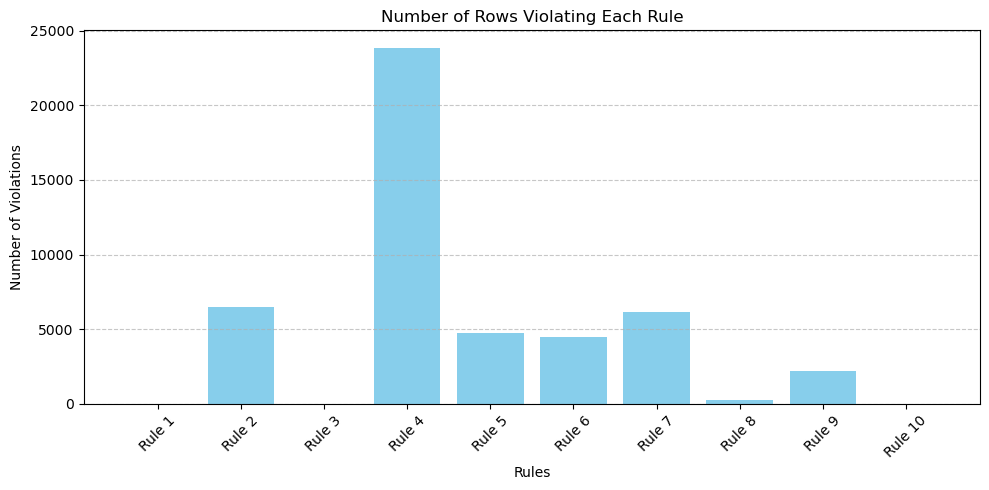

In [53]:
# List of all 10 rule conditions
all_rules = [rule_1, rule_2, rule_3, rule_4, rule_5, rule_6, rule_7, rule_8, rule_9, rule_10]
rule_names = [f"Rule {i+1}" for i in range(len(all_rules))]

# Count how many rows each rule flagged as a violation
violation_counts = [rule.sum() for rule in all_rules]

# Plot the histogram
plt.figure(figsize=(10, 5))
plt.bar(rule_names, violation_counts, color='skyblue')
plt.title("Number of Rows Violating Each Rule")
plt.xlabel("Rules")
plt.ylabel("Number of Violations")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [54]:
# Create a combined mask where any of the rules are violated
combined_violations = all_rules[0]
for rule in all_rules[1:]:
    combined_violations |= rule

# Count the number of rows that violated at least one rule
at_least_one_violation_count = combined_violations.sum()
print(f"Number of rows that violated at least one rule: {at_least_one_violation_count}")

Number of rows that violated at least one rule: 37930


## B) Statistical Detection

### B1) Z-Score

In [57]:
# Step 1: Copy the DataFrame to avoid modifying the original
df_zscore = df_preprocessed.copy()

# Step 2: Calculate Z-scores
df_zscore[columns_to_use] = df_zscore[columns_to_use].apply(zscore)

# Step 3: Set a Z-score threshold (e.g., 3 standard deviations from the mean)
threshold = 3  # You can modify this value to control the strictness

# Step 4: Identify outliers
df_zscore['zscore_anomaly'] = (df_zscore[columns_to_use].abs() > threshold).any(axis=1)

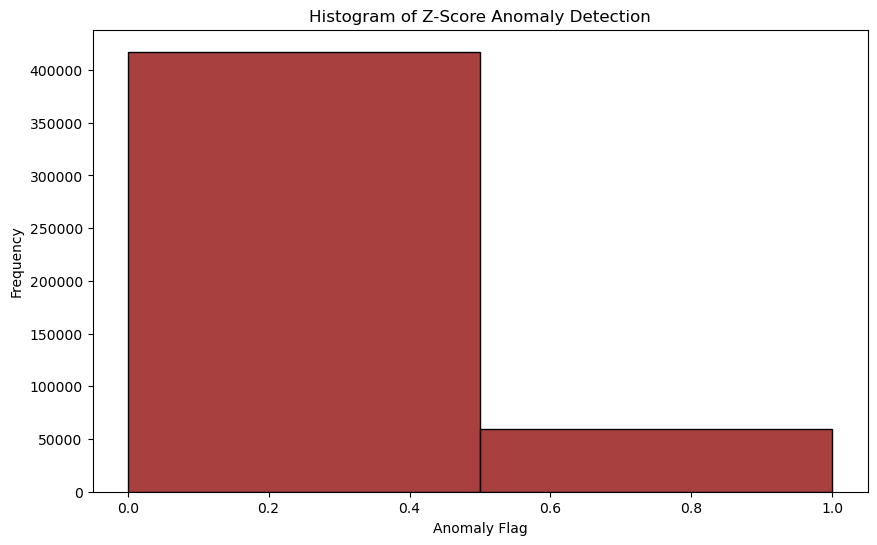

Number of anomalies detected (Z-Score): 59285


In [58]:
# Step 5: Visualize anomalies (optional)
plt.figure(figsize=(10, 6))
sns.histplot(df_zscore['zscore_anomaly'], bins=2, kde=False, color='darkred')
plt.title("Histogram of Z-Score Anomaly Detection")
plt.xlabel("Anomaly Flag")
plt.ylabel("Frequency")
plt.show()

# Step 6: Count the number of anomalies detected
num_anomalies = df_zscore['zscore_anomaly'].sum()
print(f"Number of anomalies detected (Z-Score): {num_anomalies}")

### B2) IQR

In [60]:
# Step 1: Copy the DataFrame to avoid modifying the original
df_iqr = df_preprocessed.copy()

# Step 2: Define a function to calculate the IQR and detect outliers
def iqr_outliers(df, columns, multiplier=1.5):
    outliers = pd.DataFrame(index=df.index)
    for col in columns:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1  # Interquartile Range
        lower_bound = Q1 - multiplier * IQR  # Lower bound for outliers
        upper_bound = Q3 + multiplier * IQR  # Upper bound for outliers
        outliers[col] = (df[col] < lower_bound) | (df[col] > upper_bound)  # Flag outliers
    return outliers.any(axis=1)  # Return True for rows with outliers

# Step 3: Apply IQR detection 
df_iqr['iqr_anomaly'] = iqr_outliers(df_iqr, columns_to_use)

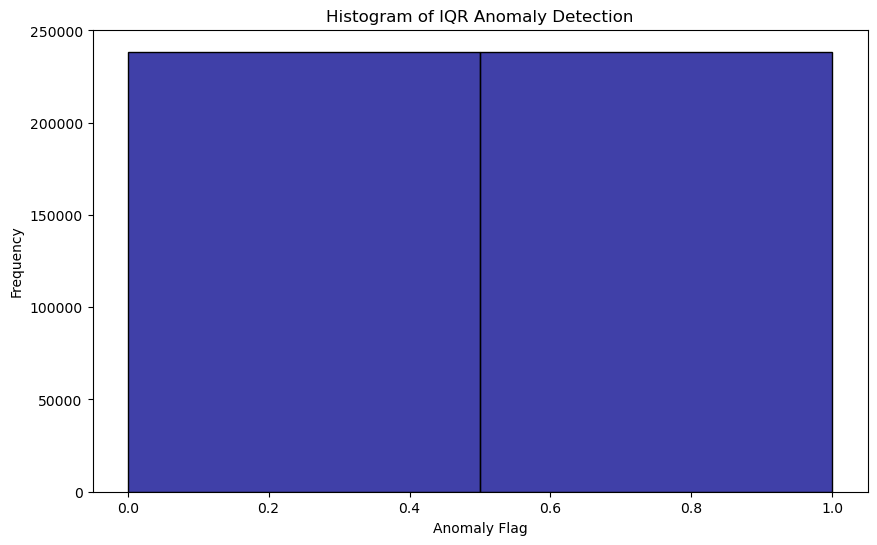

Number of anomalies detected (IQR): 238480


In [61]:
# Step 4: Visualize anomalies (optional)
plt.figure(figsize=(10, 6))
sns.histplot(df_iqr['iqr_anomaly'], bins=2, kde=False, color='darkblue')
plt.title("Histogram of IQR Anomaly Detection")
plt.xlabel("Anomaly Flag")
plt.ylabel("Frequency")
plt.show()

# Step 5: Count the number of anomalies detected
num_anomalies = df_iqr['iqr_anomaly'].sum()
print(f"Number of anomalies detected (IQR): {num_anomalies}")

### B3) Mahalanobis Distance

In [63]:
# Step 1: Copy the DataFrame to avoid modifying the original
df_mahalanobis = df_preprocessed.copy()

# Step 2: Define a function to compute Mahalanobis Distance
def mahalanobis_distance(df, columns):
    # Mean and covariance matrix of the selected features
    mean_vec = df[columns].mean(axis=0)
    cov_matrix = np.cov(df[columns], rowvar=False)
    
    # Inverse of covariance matrix
    cov_matrix_inv = np.linalg.inv(cov_matrix)
    
    # Compute the Mahalanobis distance for each row
    distances = df[columns].apply(lambda x: distance.mahalanobis(x, mean_vec, cov_matrix_inv), axis=1)
    return distances

In [64]:
# Step 3: Apply Mahalanobis Distance
df_mahalanobis['mahalanobis_distance'] = mahalanobis_distance(df_mahalanobis, columns_to_use)

# Step 4: Define a threshold for outlier detection (e.g., chi-squared distribution, or 95% threshold)
threshold = np.percentile(df_mahalanobis['mahalanobis_distance'], 95)

# Step 5: Flag anomalies based on the threshold
df_mahalanobis['mahalanobis_anomaly'] = df_mahalanobis['mahalanobis_distance'] > threshold

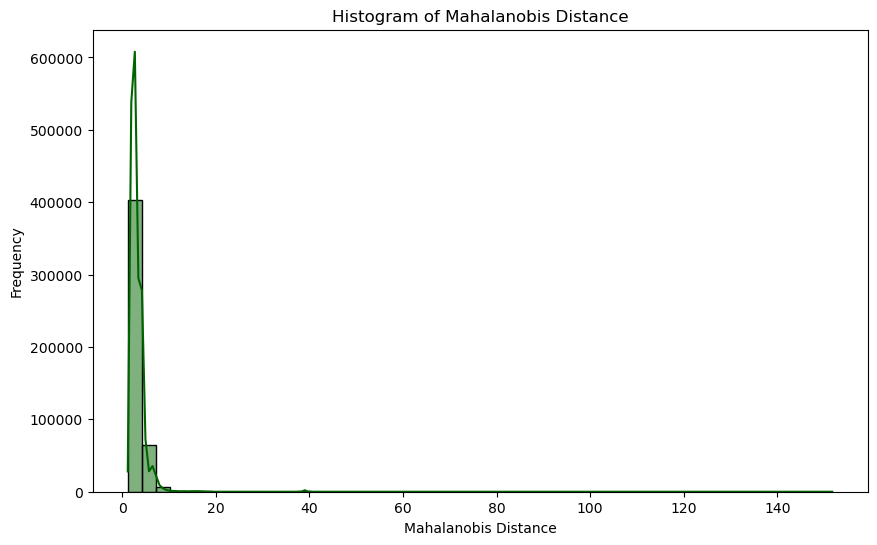

Number of anomalies detected (Mahalanobis Distance): 23835


In [65]:
# Step 6: Visualize anomalies (optional)
plt.figure(figsize=(10, 6))
sns.histplot(df_mahalanobis['mahalanobis_distance'], bins=50, kde=True, color='darkgreen')
plt.title("Histogram of Mahalanobis Distance")
plt.xlabel("Mahalanobis Distance")
plt.ylabel("Frequency")
plt.show()

# Step 7: Count the number of anomalies detected
num_anomalies = df_mahalanobis['mahalanobis_anomaly'].sum()
print(f"Number of anomalies detected (Mahalanobis Distance): {num_anomalies}")

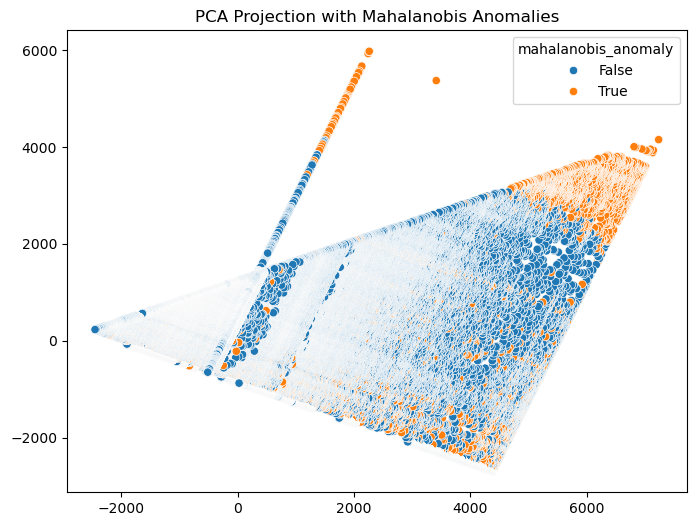

In [66]:
# Visualize Anomalies Overlaid on PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(df_mahalanobis[columns_to_use])
plt.figure(figsize=(8, 6))
sns.scatterplot(x=proj[:, 0], y=proj[:, 1], hue=df_mahalanobis['mahalanobis_anomaly'])
plt.title("PCA Projection with Mahalanobis Anomalies")
plt.show()

## C) Clustering-Based Detection

### C1) K-Means++ 

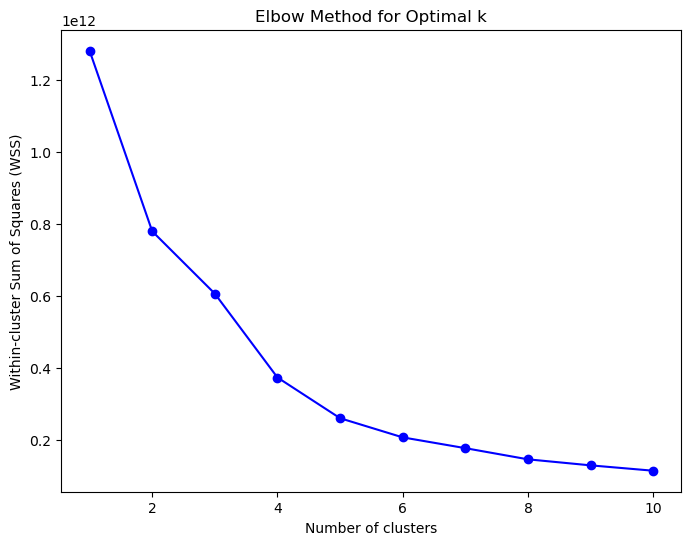

In [202]:
# Number of clusters to test (1 to 5 clusters)
k_range = range(1, 11)  
wss = []

# Calculate WSS for each k
for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(df_preprocessed[columns_to_use])  # Use the columns to include
    wss.append(kmeans.inertia_)  # Inertia is the WSS

# Plot the Elbow graph
plt.figure(figsize=(8, 6))
plt.plot(k_range, wss, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster Sum of Squares (WSS)')
plt.show()

In [203]:
# Fit the K-Means model with the optimal number of clusters
df_preprocessed_kmeans = df_preprocessed.copy()
k_optimal = 5
kmeans = KMeans(n_clusters=k_optimal, init='k-means++', random_state=42)
df_preprocessed_kmeans['cluster'] = kmeans.fit_predict(df_preprocessed_kmeans[columns_to_use])

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

In [204]:
# Calculate distance from each point to its cluster center
distances = kmeans.transform(df_preprocessed_kmeans[columns_to_use])
min_distances = np.min(distances, axis=1)  # Get the distance to the nearest cluster center

# Define an anomaly threshold (e.g., any point farther than 3 standard deviations from the mean distance)
threshold = np.mean(min_distances) + 2 * np.std(min_distances)

# Identify anomalies
df_preprocessed_kmeans['anomaly'] = min_distances > threshold

In [205]:
# Print count of anomalies
print(f'Number of anomalies detected: {df_preprocessed_kmeans["anomaly"].sum()}')

Number of anomalies detected: 15812


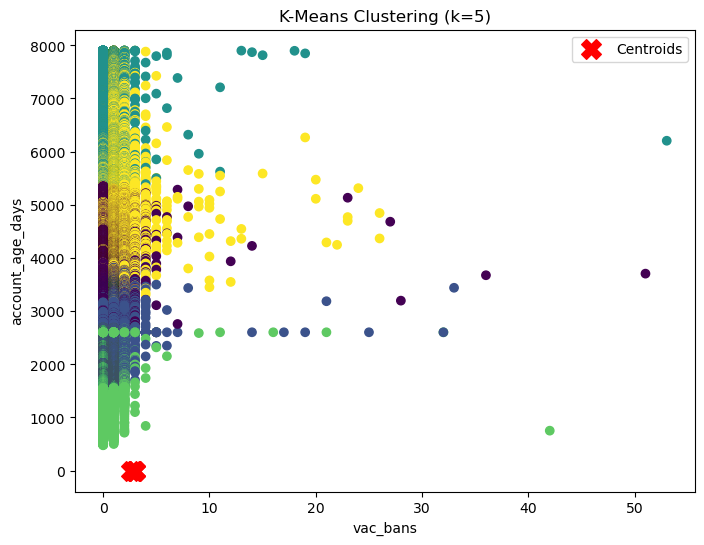

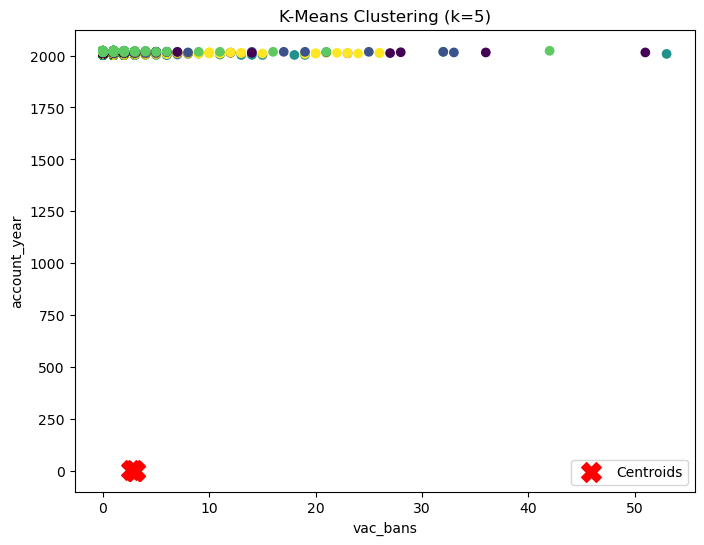

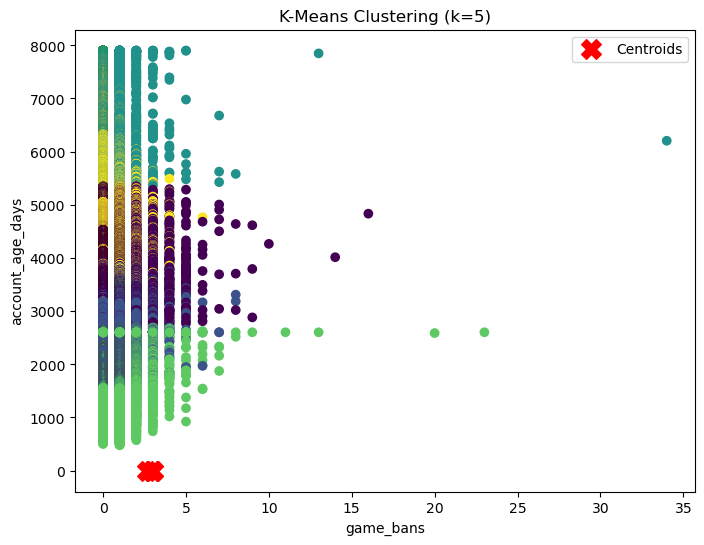

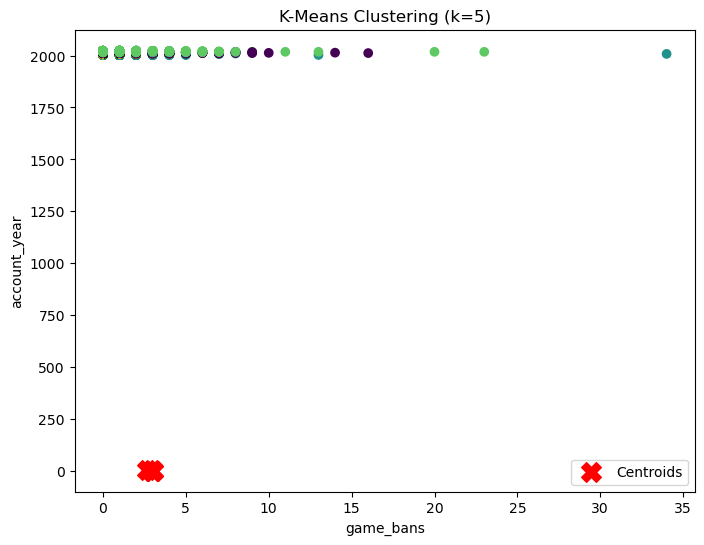

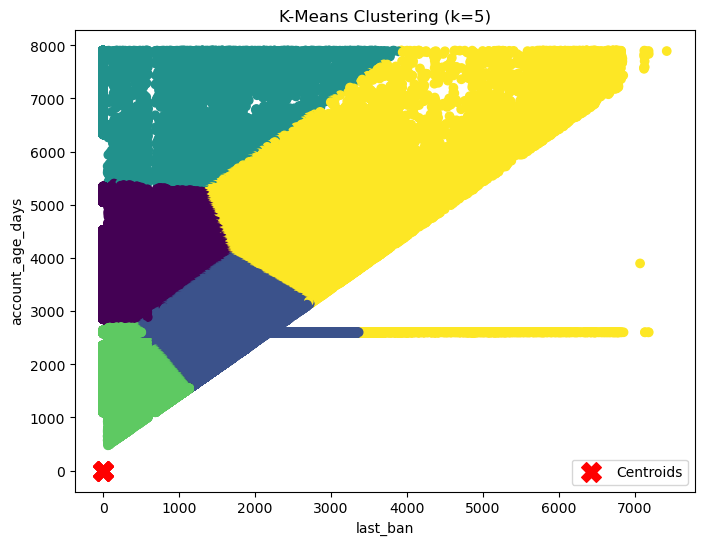

D:\Anaconda\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


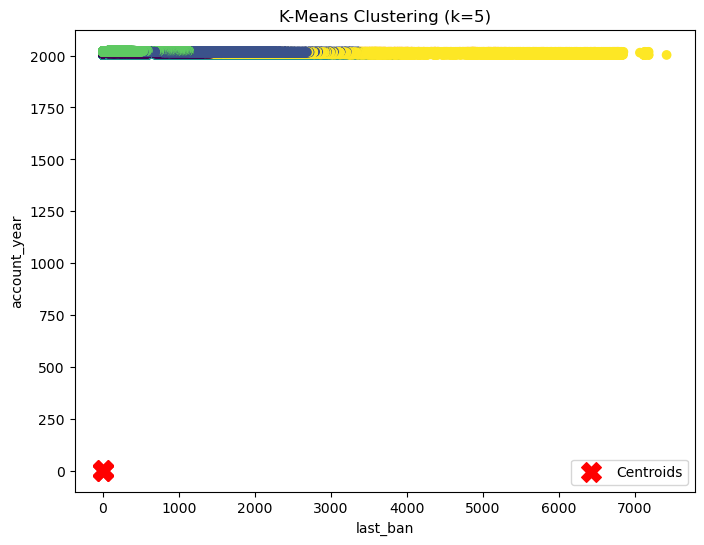

In [206]:
# Visualizing the clusters (if needed, for a 2D plot)
for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        plt.scatter(df_preprocessed_kmeans[columns_to_use[i]], df_preprocessed_kmeans[columns_to_use[j]], c=df_preprocessed_kmeans['cluster'], cmap='viridis')
        plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='X', color='red', s=200, label='Centroids')
        plt.title(f'K-Means Clustering (k={k_optimal})')
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.legend()
        plt.show()

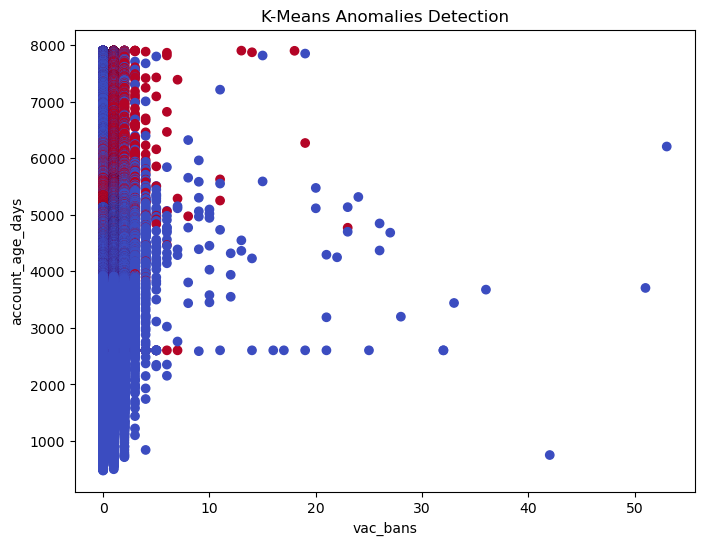

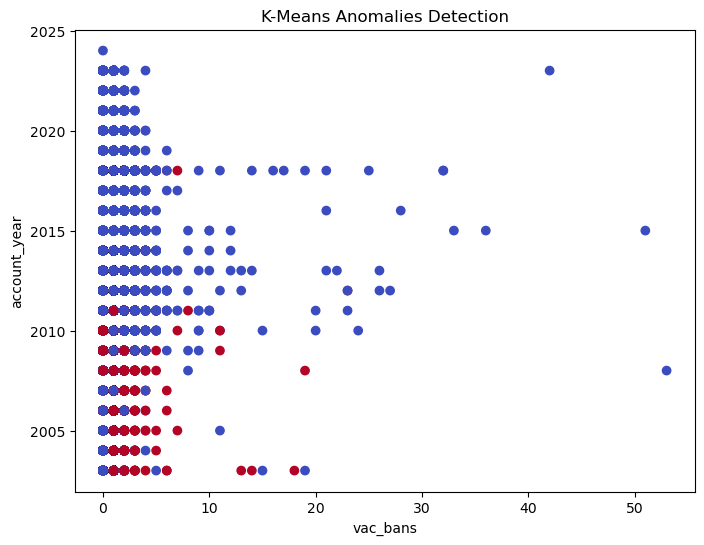

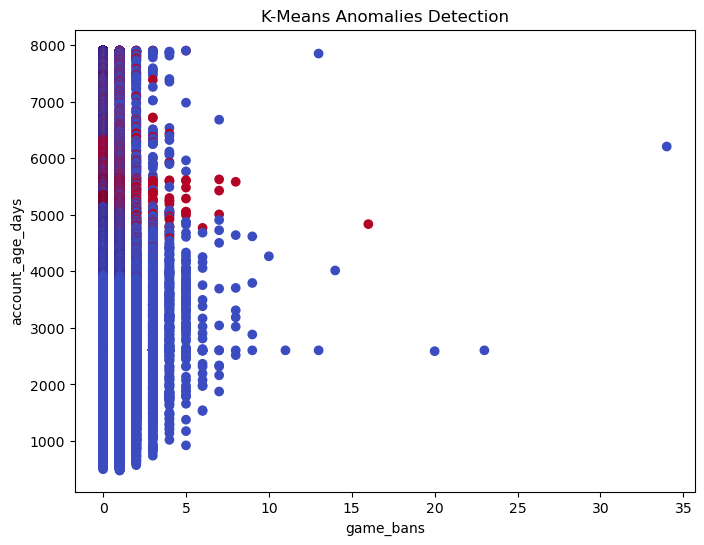

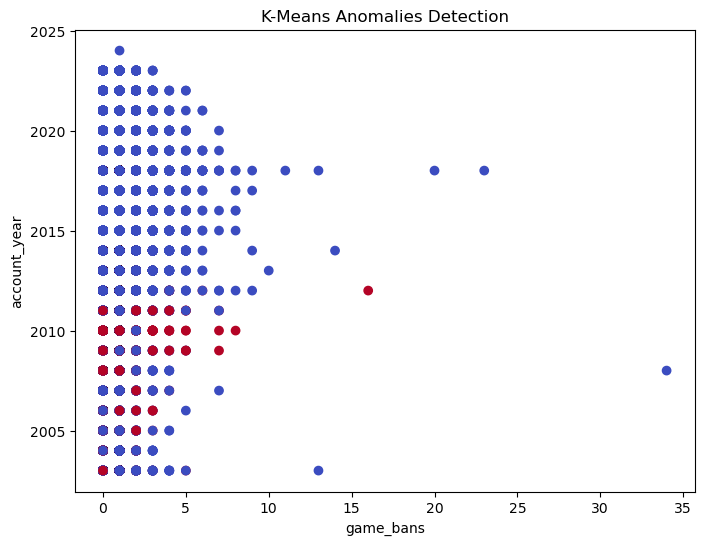

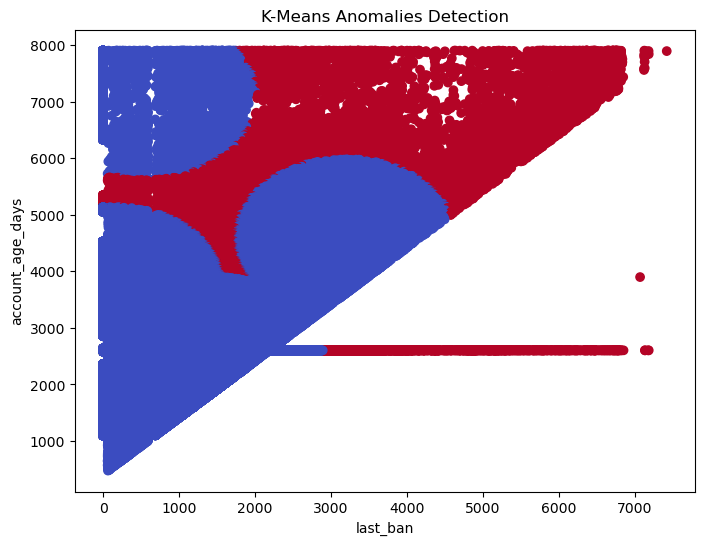

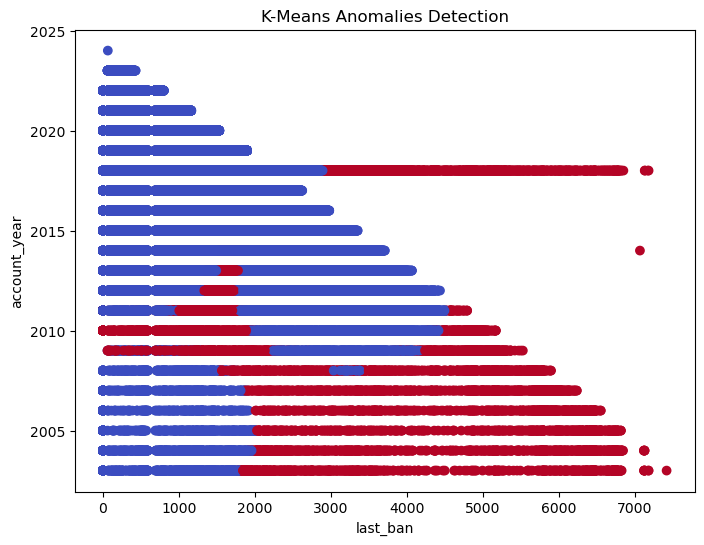

In [207]:
# Visualize anomalies
for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        plt.scatter(df_preprocessed_kmeans[columns_to_use[i]], df_preprocessed_kmeans[columns_to_use[j]], c=df_preprocessed_kmeans['anomaly'], cmap='coolwarm')
        plt.title('K-Means Anomalies Detection')
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.show()

In [208]:
# Inspect top-N outliers for qualitative validation
df_preprocessed_kmeans['distance_to_cluster'] = min_distances
top_outliers = df_preprocessed_kmeans[df_preprocessed_kmeans['anomaly']].sort_values(by='distance_to_cluster', ascending=False).head(10)

# Show identifying details
print(top_outliers[['steam_id', 'distance_to_cluster']])

               steam_id  distance_to_cluster
1349  76561197961133072          5406.851500
1252  76561197961025984          5222.556077
2722  76561197962722352          5188.814011
904   76561197960720416          5187.788023
184   76561197960323200          5184.420077
2821  76561197962855616          5140.310839
3476  76561197963597504          5123.010380
3261  76561197963394848          5121.577091
3685  76561197963830784          5108.692068
4427  76561197965355632          5060.933825


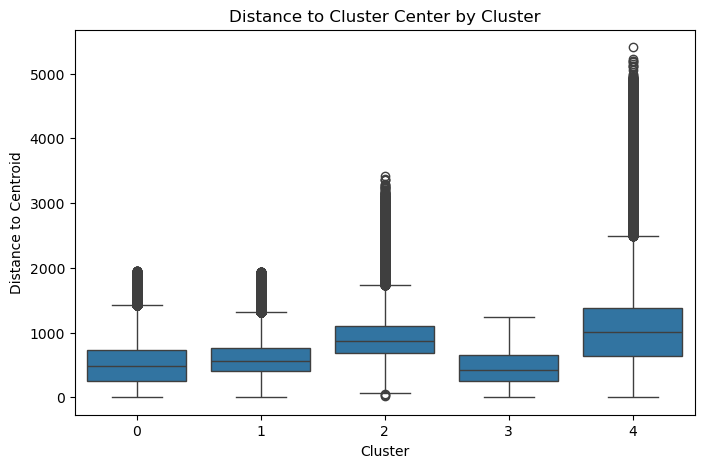

In [211]:
# Plot boxplot of distances per cluster
plt.figure(figsize=(8, 5))
sns.boxplot(x='cluster', y='distance_to_cluster', data=df_preprocessed_kmeans)
plt.title('Distance to Cluster Center by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Distance to Centroid')
plt.show()

<Axes: title={'center': 'Cluster Sizes'}, xlabel='cluster'>

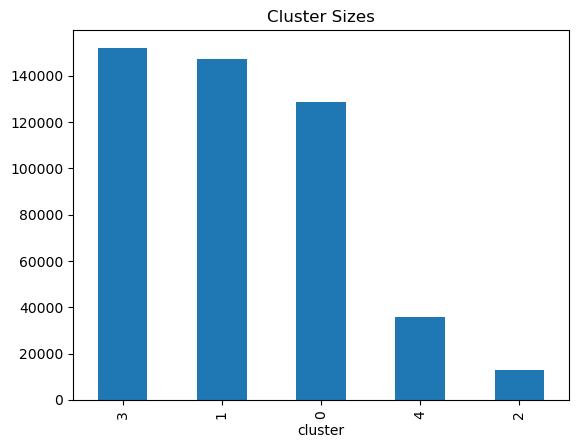

In [214]:
# Cluster Size Distribution
df_preprocessed_kmeans['cluster'].value_counts().plot(kind='bar', title='Cluster Sizes')

### C2) HDBSCAN

In [79]:
# Fit HDBSCAN on selected features
df_preprocessed_hdbscan = df_preprocessed.copy()
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, min_samples=10, prediction_data=True)
cluster_labels = clusterer.fit_predict(df_preprocessed_hdbscan[columns_to_use])

In [80]:
# Store Cluster Labels and Identify Outliers
df_preprocessed_hdbscan['hdbscan_cluster'] = cluster_labels
df_preprocessed_hdbscan['hdbscan_anomaly'] = df_preprocessed_hdbscan['hdbscan_cluster'] == -1

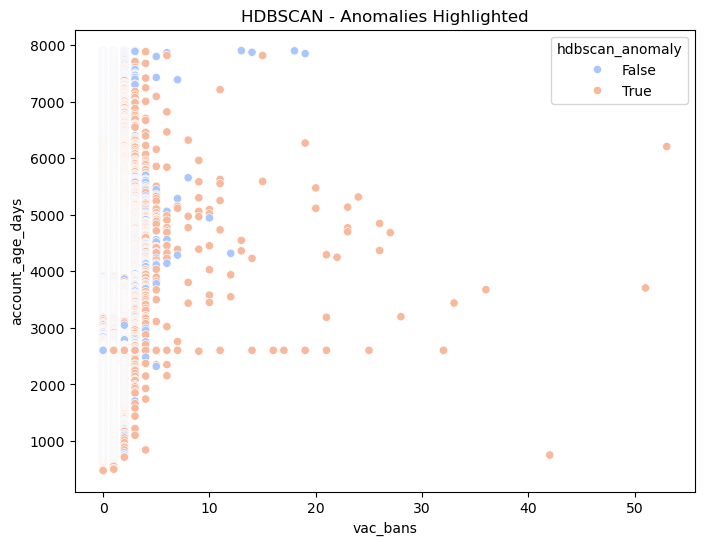

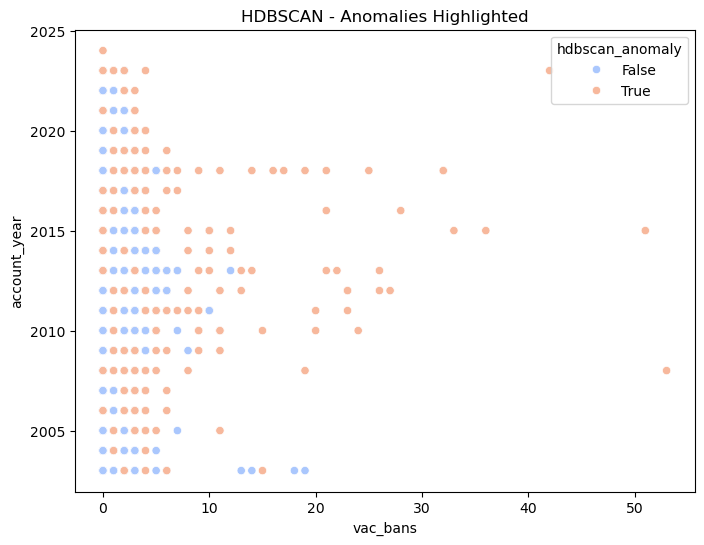

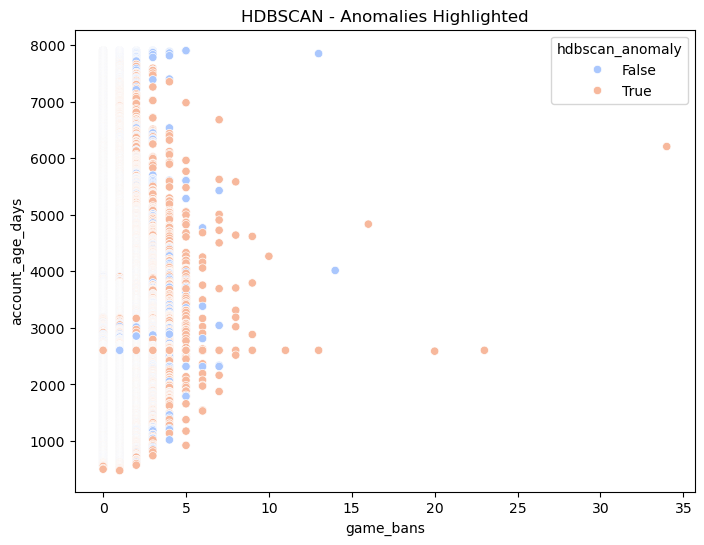

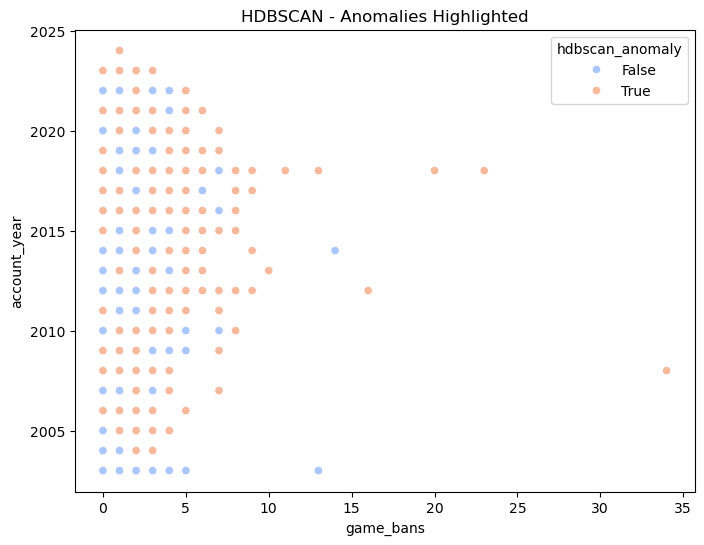

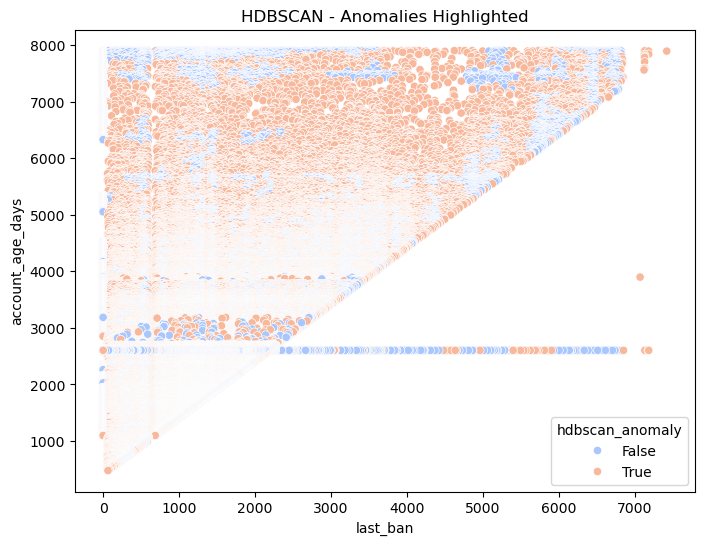

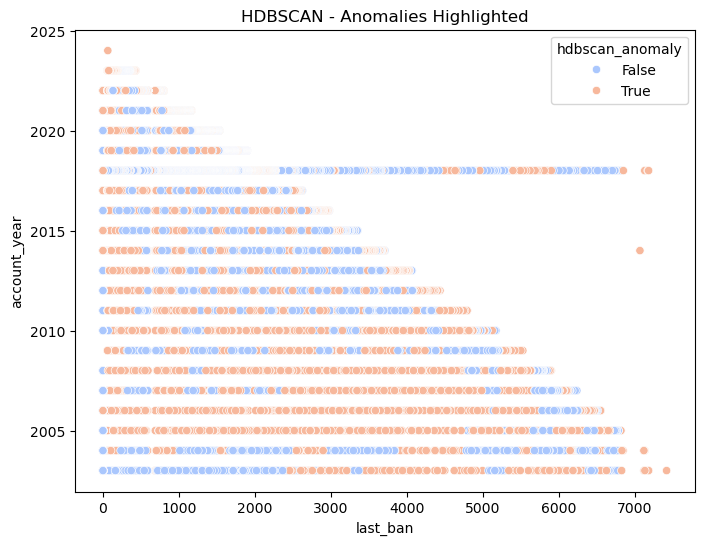

In [81]:
# Visualize the Anomalies
for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=df_preprocessed_hdbscan[columns_to_use[i]],
            y=df_preprocessed_hdbscan[columns_to_use[j]],
            hue=df_preprocessed_hdbscan['hdbscan_anomaly'],
            palette='coolwarm'
        )
        plt.title("HDBSCAN - Anomalies Highlighted")
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.show()

In [82]:
# Print Summary
num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
num_anomalies = df_preprocessed_hdbscan['hdbscan_anomaly'].sum()

print(f"Number of clusters found: {num_clusters}")
print(f"Number of anomalies detected: {num_anomalies}")

Number of clusters found: 2711
Number of anomalies detected: 147153


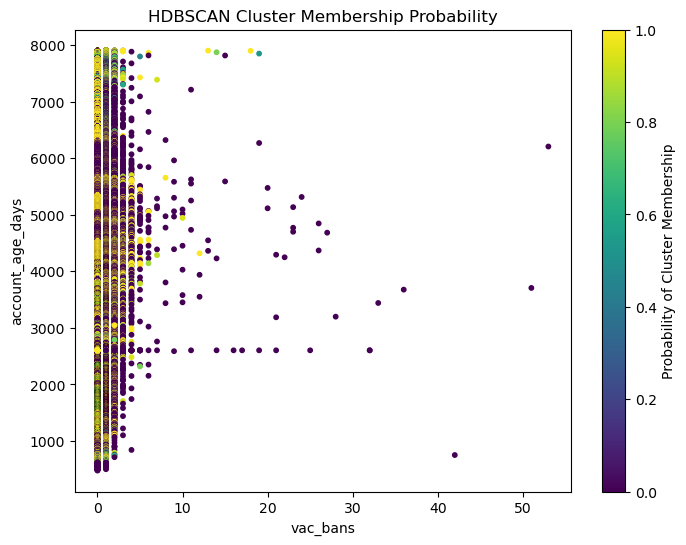

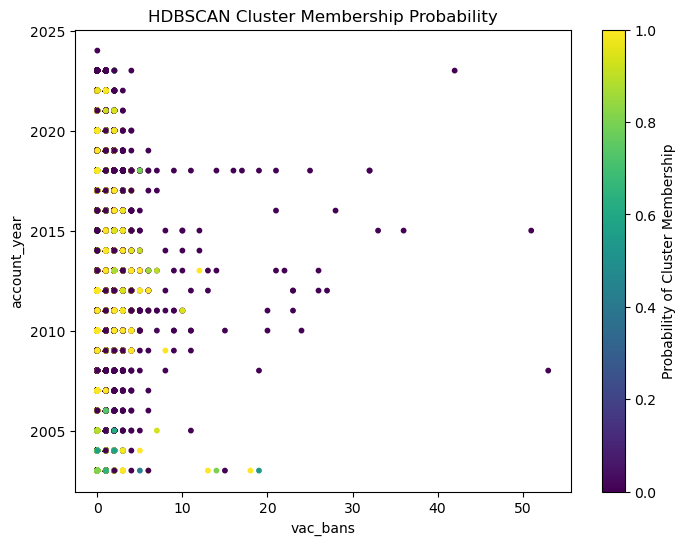

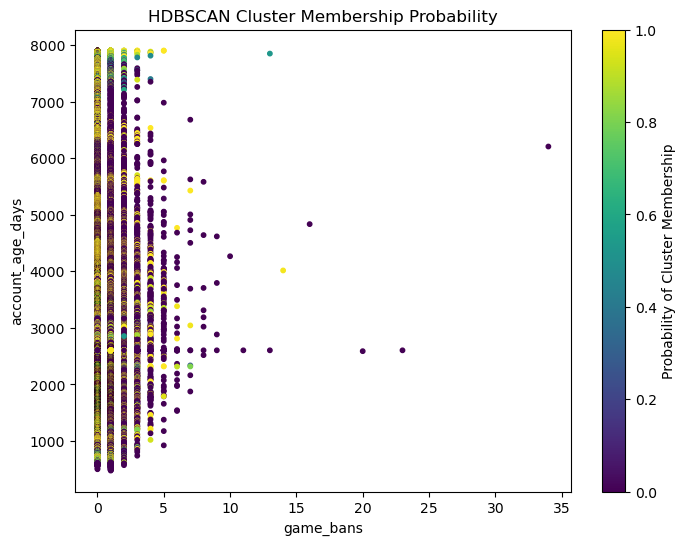

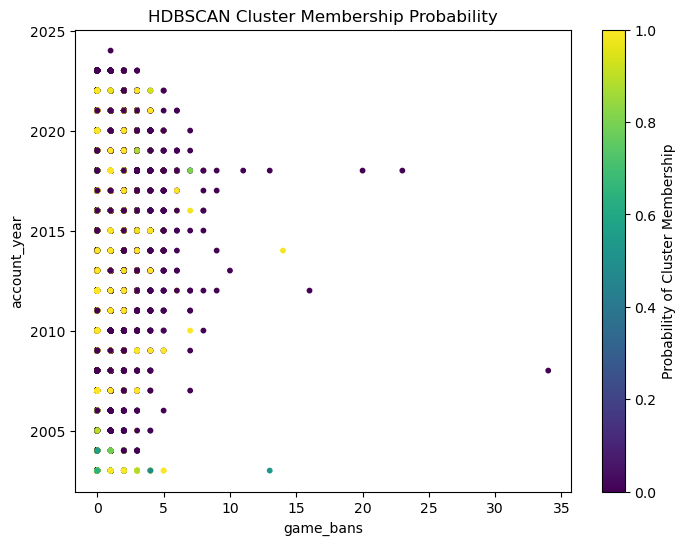

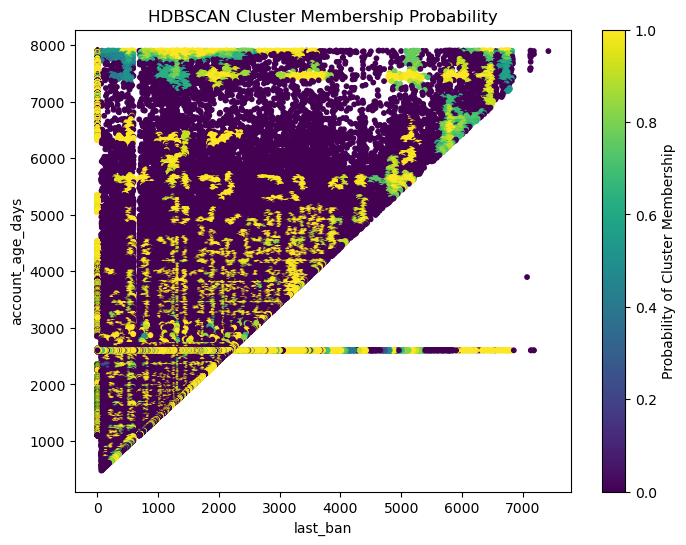

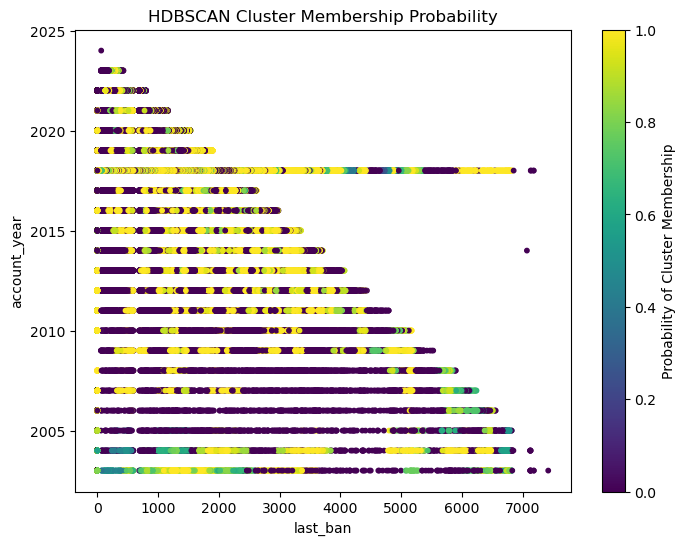

In [83]:
# Visualize Cluster Membership Strength (Soft Clustering)
df_preprocessed_hdbscan['hdbscan_probability'] = clusterer.probabilities_

for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        sc = plt.scatter(
            df_preprocessed_hdbscan[columns_to_use[i]],
            df_preprocessed_hdbscan[columns_to_use[j]],
            c=df_preprocessed_hdbscan['hdbscan_probability'],
            cmap='viridis',
            s=10
        )
        plt.colorbar(sc, label='Probability of Cluster Membership')
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.title('HDBSCAN Cluster Membership Probability')
        plt.show()

In [84]:
# Cluster-Specific Summary Statistics
cluster_summary = df_preprocessed_hdbscan[df_preprocessed_hdbscan['hdbscan_cluster'] != -1].groupby('hdbscan_cluster')[columns_to_use].mean()
display(cluster_summary)

communityvisibilitystate  vac_bans  game_bans  economy_ban  \
hdbscan_cluster                                                               
0                                3.000000  0.000000   0.000000          0.0   
1                                1.595506  1.011236   0.000000          0.0   
2                                1.600000  1.033333   0.000000          0.0   
3                                1.630137  1.136986   0.000000          0.0   
4                                1.644776  1.176119   0.000000          0.0   
...                                   ...       ...        ...          ...   
2706                             3.000000  0.935897   0.064103          0.0   
2707                             3.000000  1.000000   0.006667          0.0   
2708                             3.000000  0.991304   0.008696          0.0   
2709                             3.000000  0.900000   0.100000          0.0   
2710                             3.000000  0.949405   0.052083          0.0   

                    last_ban  steam_level  friends_count  game_count  \
hdbscan_cluster                                                        
0                   0.000000     0.372056       0.546013    0.183919   
1                6568.831461     0.281205       0.459982    0.148759   
2                6072.300000     0.281205       0.459982    0.148759   
3                4370.424658     0.281205       0.459982    0.148759   
4                3960.901493     0.281205       0.459982    0.148759   
...                      ...          ...            ...         ...   
2706             1134.512821     0.009485       0.049576    0.139761   
2707             1224.973333     0.017278       0.062138    0.146869   
2708             1206.704348     0.015132       0.047301    0.135690   
2709             1137.140000     0.000000       0.008362    0.129054   
2710             1110.357143     0.006573       0.035925    0.148548   

                 total_playtime  cs2_playtime  account_age_days  account_year  \
hdbscan_cluster                                                                 
0                      0.238989      0.258746       4340.780272   2012.918748   
1                      0.000000      0.000000       2602.000000   2018.000000   
2                      0.000000      0.000000       2602.000000   2018.000000   
3                      0.000000      0.000000       2602.000000   2018.000000   
4                      0.000000      0.000000       2602.000000   2018.000000   
...                         ...           ...               ...           ...   
2706                   0.023180      0.027739       1560.256410   2021.000000   
2707                   0.002687      0.003215       1657.320000   2020.000000   
2708                   0.047918      0.057203       1646.265217   2020.000000   
2709                   0.042949      0.051344       1556.980000   2021.000000   
2710                   0.000426      0.000510       1527.514881   2021.000000   

                 game_count_missing  
hdbscan_cluster                      
0                          0.638002  
1                          1.000000  
2                          1.000000  
3                          1.000000  
4                          1.000000  
...                             ...  
2706                       0.935897  
2707                       0.986667  
2708                       0.860870  
2709                       0.860000  
2710                       0.998512  

[2711 rows x 13 columns]

Total anomalies detected (noise or low prob): 152055


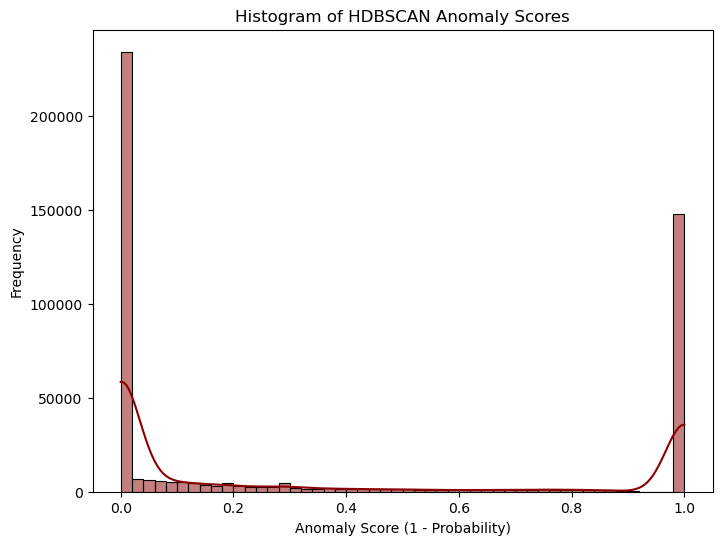

In [85]:
# Anomaly Likelihood Based on Distance + Probability
# 1. Identify Noise Points (cluster = -1)
df_preprocessed_hdbscan['is_noise'] = (df_preprocessed_hdbscan['hdbscan_cluster'] == -1)

# 2. Set a probability threshold to catch weak members
prob_threshold = 0.2
df_preprocessed_hdbscan['low_prob'] = df_preprocessed_hdbscan['hdbscan_probability'] < prob_threshold

# 3. Compute an anomaly score (higher = more anomalous)
df_preprocessed_hdbscan['hdbscan_anomaly_score'] = 1 - df_preprocessed_hdbscan['hdbscan_probability']

# 4. Combine all signals into a final binary anomaly flag (optional)
df_preprocessed_hdbscan['hdbscan_anomaly'] = df_preprocessed_hdbscan['is_noise'] | df_preprocessed_hdbscan['low_prob']

# 5. How many anomalies were detected?
print(f"Total anomalies detected (noise or low prob): {df_preprocessed_hdbscan['hdbscan_anomaly'].sum()}")

# 6. Visualize anomaly score
plt.figure(figsize=(8, 6))
sns.histplot(df_preprocessed_hdbscan['hdbscan_anomaly_score'], bins=50, kde=True, color='darkred')
plt.title("Histogram of HDBSCAN Anomaly Scores")
plt.xlabel("Anomaly Score (1 - Probability)")
plt.ylabel("Frequency")
plt.show()

In [86]:
# View the top N most anomalous points
top_anomalies = df_preprocessed_hdbscan.sort_values('hdbscan_anomaly_score', ascending=False).head(10)
cols_to_display = ['hdbscan_anomaly_score', 'hdbscan_probability', 'hdbscan_cluster'] + list(columns_to_use)
display(top_anomalies[cols_to_display])

hdbscan_anomaly_score  hdbscan_probability  hdbscan_cluster  \
238347                    1.0                  0.0               -1   
229622                    1.0                  0.0               -1   
229598                    1.0                  0.0               -1   
229599                    1.0                  0.0               -1   
229605                    1.0                  0.0               -1   
229607                    1.0                  0.0               -1   
229609                    1.0                  0.0               -1   
229610                    1.0                  0.0               -1   
229611                    1.0                  0.0               -1   
229613                    1.0                  0.0               -1   

        communityvisibilitystate  vac_bans  game_bans  economy_ban  last_ban  \
238347                         3         1          0            0     817.0   
229622                         3         0          1            0    1480.0   
229598                         3         2          0            0    1319.0   
229599                         3         1          0            0    2095.0   
229605                         3         0          1            0     289.0   
229607                         3         2          1            0     102.0   
229609                         3         2          2            0     230.0   
229610                         3         1          0            0    2107.0   
229611                         3         0          4            0     267.0   
229613                         3         2          2            0    1000.0   

        steam_level  friends_count  game_count  total_playtime  cs2_playtime  \
238347     0.346582       0.467723    0.148759        0.000000      0.000000   
229622     0.249042       0.608437    0.148759        0.000000      0.000000   
229598     0.503203       0.623069    0.148759        0.000000      0.000000   
229599     0.266131       0.428618    0.148759        0.000000      0.000000   
229605     0.249042       0.302916    0.148759        0.000000      0.000000   
229607     0.281205       0.211729    0.242306        0.698352      0.689610   
229609     0.306888       0.722638    0.438488        0.000000      0.000000   
229610     0.249042       0.315454    0.148759        0.000000      0.000000   
229611     0.447490       0.634131    0.411868        0.725088      0.492027   
229613     0.354842       0.574821    0.148759        0.000000      0.000000   

        account_age_days  account_year  game_count_missing  
238347              2592          2018                   1  
229622              2674          2018                   1  
229598              2675          2018                   1  
229599              2675          2018                   1  
229605              2674          2018                   1  
229607              2674          2018                   0  
229609              2674          2018                   0  
229610              2674          2018                   1  
229611              2674          2018                   0  
229613              2674          2018                   1

### C3) LOF (Local Outlier Factor)

In [90]:
# Define the features to use
df_preprocessed_lof = df_preprocessed.copy()
X_lof = df_preprocessed_lof[columns_to_use]

# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=20, contamination='auto', metric='euclidean')

In [91]:
# Fit the model and get predictions
# -1 = outlier, 1 = inlier
lof_predictions = lof.fit_predict(X_lof)

# Negative Outlier Factor: the lower, the more anomalous
lof_scores = lof.negative_outlier_factor_

# Add results to the DataFrame
df_preprocessed_lof['lof_anomaly'] = lof_predictions == -1
df_preprocessed_lof['lof_score'] = -lof_scores  # Flip sign for easier interpretation (higher = more anomalous)

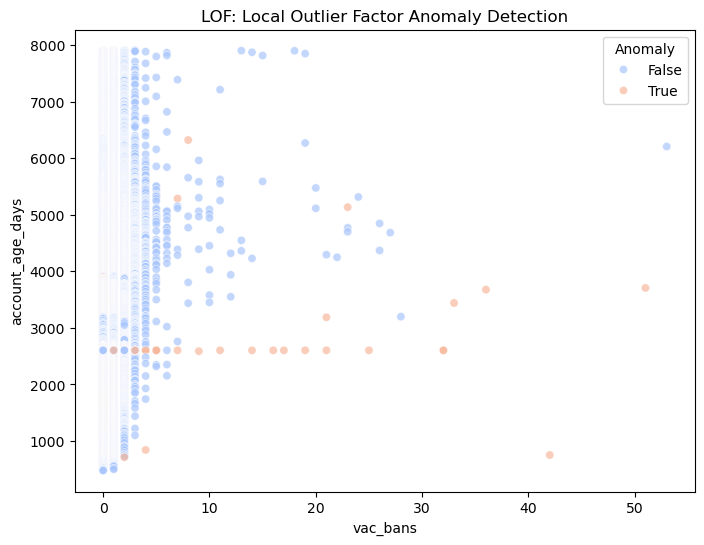

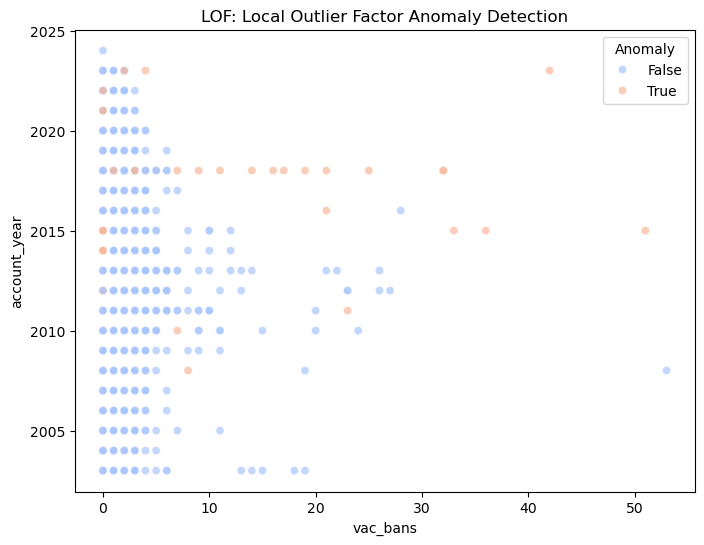

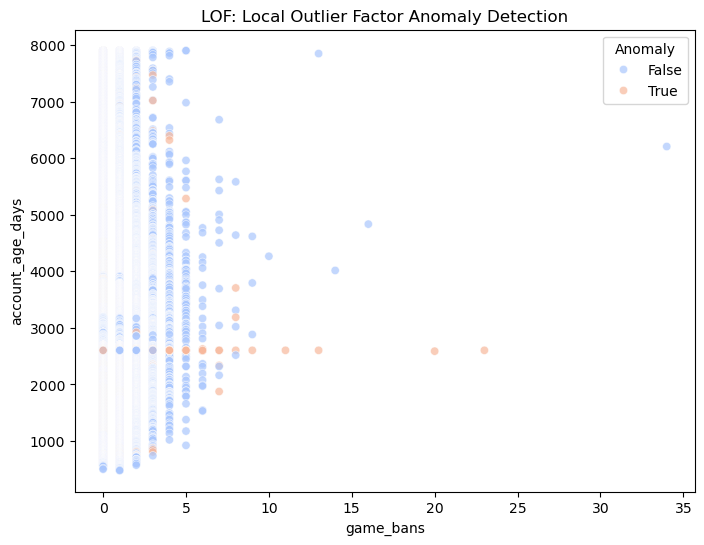

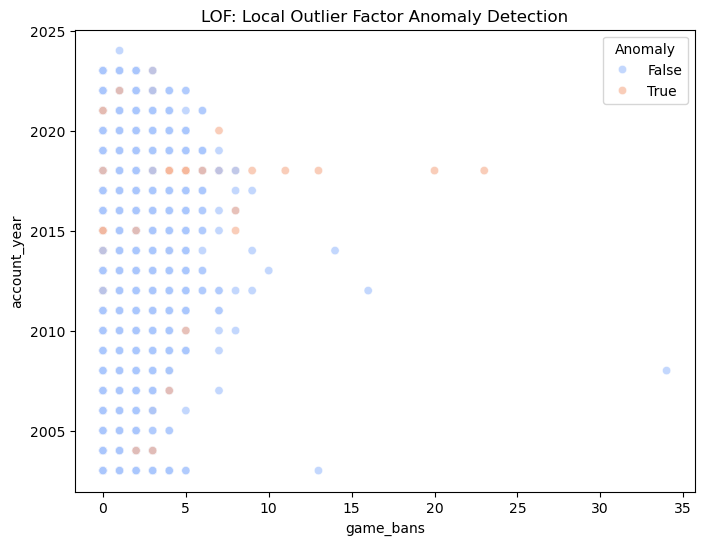

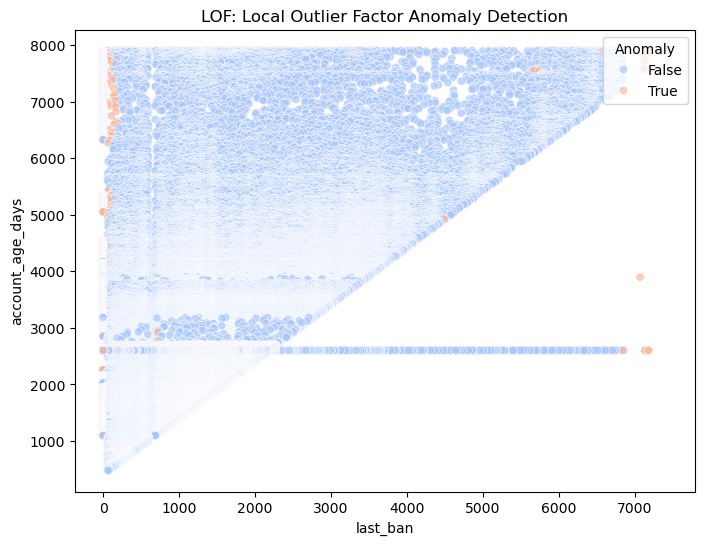

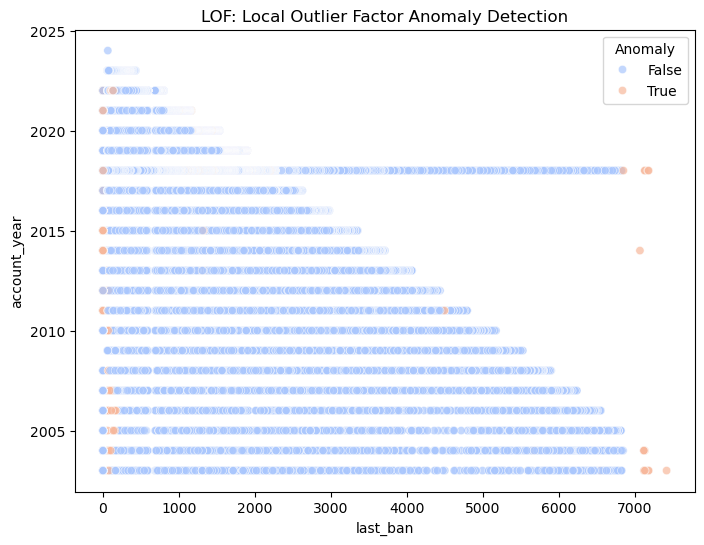

In [93]:
# Visualize anomalies in 2D
for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=df_preprocessed_lof[columns_to_use[i]],
            y=df_preprocessed_lof[columns_to_use[j]],
            hue=df_preprocessed_lof['lof_anomaly'],
            palette='coolwarm',
            alpha=0.7
        )
        plt.title("LOF: Local Outlier Factor Anomaly Detection")
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.legend(title="Anomaly", loc='upper right')
        plt.show()

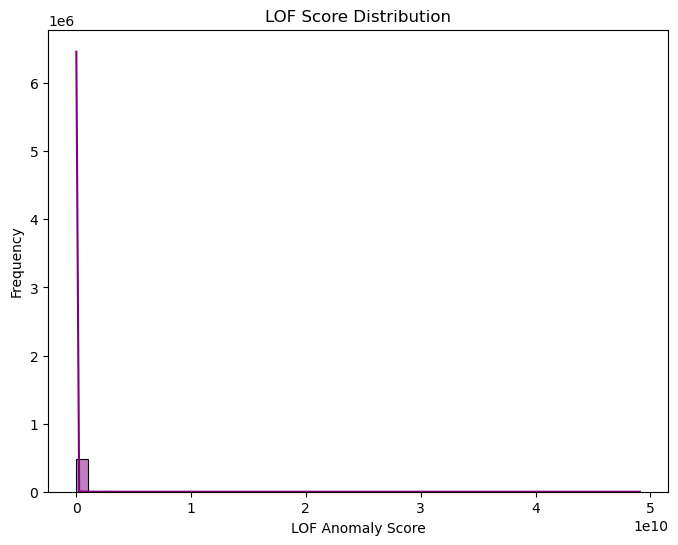

In [94]:
# Visualize LOF score distribution
plt.figure(figsize=(8, 6))
sns.histplot(df_preprocessed_lof['lof_score'], bins=50, kde=True, color='purple')
plt.title("LOF Score Distribution")
plt.xlabel("LOF Anomaly Score")
plt.ylabel("Frequency")
plt.show()

In [95]:
# Summary: Count of anomalies detected
num_anomalies_lof = df_preprocessed_lof['lof_anomaly'].sum()
print(f"Number of anomalies detected using LOF: {num_anomalies_lof}")

# Display Top N Anomalies based on LOF scores (Top 10 anomalies)
top_anomalies_lof = df_preprocessed_lof.sort_values('lof_score', ascending=False).head(10)
cols_to_display = ['lof_score', 'lof_anomaly'] + list(columns_to_use)
display(top_anomalies_lof[cols_to_display])

Number of anomalies detected using LOF: 27550


lof_score  lof_anomaly  communityvisibilitystate  vac_bans  \
474451  4.909958e+10         True                         3         0   
236776  3.167931e+10         True                         3         1   
474632  2.905000e+10         True                         3         0   
474980  2.853440e+10         True                         3         0   
474946  2.823814e+10         True                         3         0   
474911  2.823381e+10         True                         3         0   
474942  2.801266e+10         True                         3         0   
474877  2.801266e+10         True                         3         0   
474900  2.801266e+10         True                         3         0   
474921  2.801266e+10         True                         3         0   

        game_bans  economy_ban  last_ban  steam_level  friends_count  \
474451          1            0     125.0     0.000000       0.091187   
236776          0            0    1301.0     0.249042       0.273560   
474632          1            0     127.0     0.000000       0.091187   
474980          1            0     136.0     0.088710       0.211729   
474946          1            0     136.0     0.088710       0.273560   
474911          1            0     136.0     0.088710       0.235714   
474942          1            0     127.0     0.000000       0.000000   
474877          1            0     127.0     0.000000       0.000000   
474900          1            0     127.0     0.000000       0.000000   
474921          1            0     127.0     0.000000       0.000000   

        game_count  total_playtime  cs2_playtime  account_age_days  \
474451    0.148759        0.000000      0.000000               766   
236776    0.148759        0.000000      0.000000              2605   
474632    0.148759        0.000000      0.000000               759   
474980    0.007049        0.377256      0.451454               753   
474946    0.148759        0.000000      0.000000               754   
474911    0.148759        0.000000      0.000000               754   
474942    0.148759        0.000000      0.000000               756   
474877    0.148759        0.000000      0.000000               756   
474900    0.148759        0.000000      0.000000               756   
474921    0.148759        0.000000      0.000000               756   

        account_year  game_count_missing  
474451          2023                   1  
236776          2018                   1  
474632          2023                   1  
474980          2023                   0  
474946          2023                   1  
474911          2023                   1  
474942          2023                   1  
474877          2023                   1  
474900          2023                   1  
474921          2023                   1

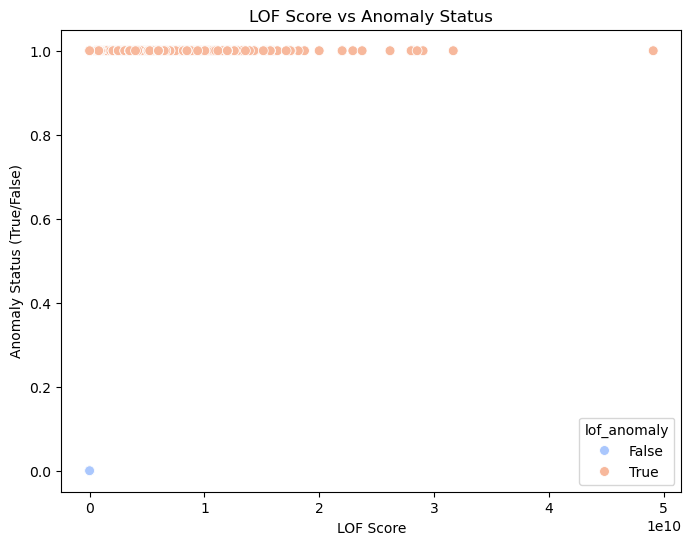

In [96]:
# Visualizing the relationship between LOF score and anomaly status
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=df_preprocessed_lof['lof_score'], 
    y=df_preprocessed_lof['lof_anomaly'], 
    hue=df_preprocessed_lof['lof_anomaly'], 
    palette='coolwarm', 
    s=50
)
plt.title('LOF Score vs Anomaly Status')
plt.xlabel('LOF Score')
plt.ylabel('Anomaly Status (True/False)')
plt.show()

Text(0.5, 1.0, 'LOF Score Distribution by Anomaly Status')

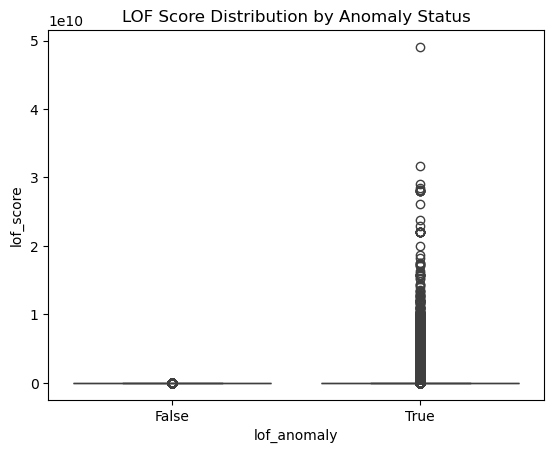

In [97]:
# check inlier vs. outlier spread with boxplots
sns.boxplot(x='lof_anomaly', y='lof_score', data=df_preprocessed_lof)
plt.title("LOF Score Distribution by Anomaly Status")

<Axes: >

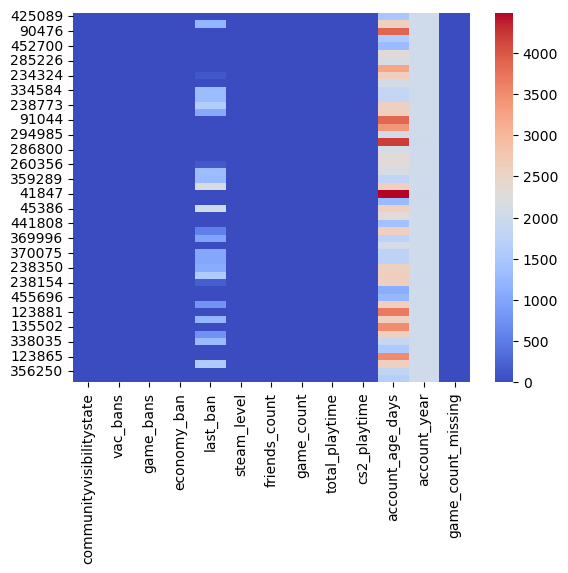

In [98]:
# LOF Outlier Heatmaps for Features
anomalies_only = df_preprocessed_lof[df_preprocessed_lof['lof_anomaly']]
sns.heatmap(anomalies_only[columns_to_use].sample(50), cmap='coolwarm')

## D) Machine-Learning Based Detection

### D1) Isolation Forest

In [101]:
# Create a fresh copy to keep things clean
df_preprocessed_iso = df_preprocessed.copy()

# Extract the features for model training
X_iso = df_preprocessed_iso[columns_to_use]

# Initialize the Isolation Forest
iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=42)

In [102]:
# Fit the Isolation Forest model and predict anomalies
iso_model.fit(X_iso)

# Predict: -1 = anomaly, 1 = normal
iso_preds = iso_model.predict(X_iso)

# Anomaly score (the lower, the more anomalous)
iso_scores = iso_model.decision_function(X_iso)  # Higher scores = more normal

# Store results in the DataFrame
df_preprocessed_iso['iso_anomaly'] = iso_preds == -1
df_preprocessed_iso['iso_score'] = -iso_scores  # Flip to make higher = more anomalous

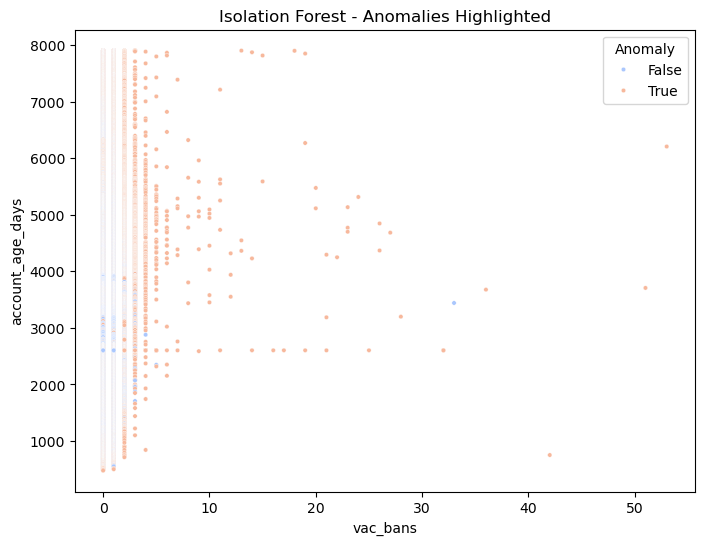

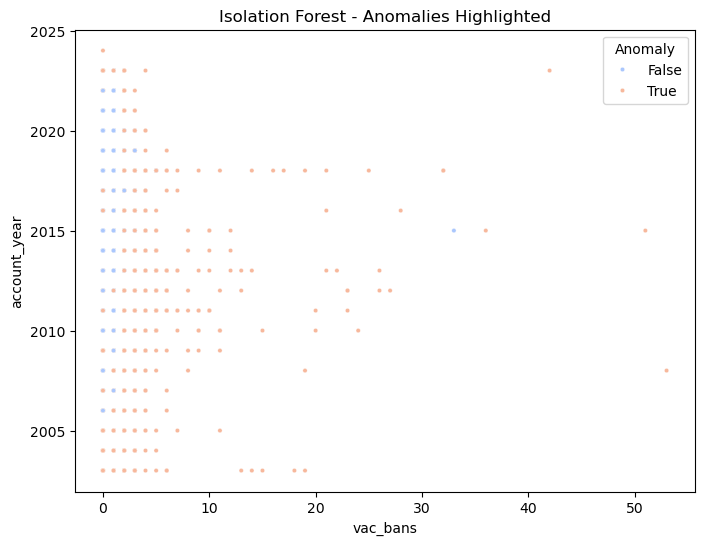

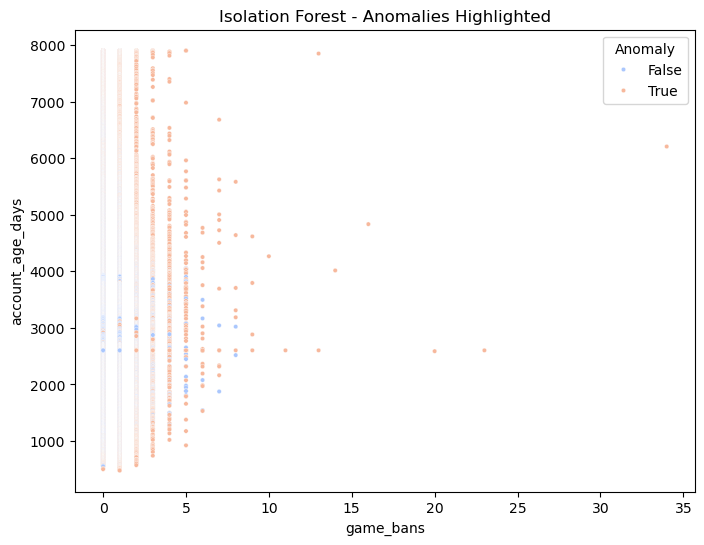

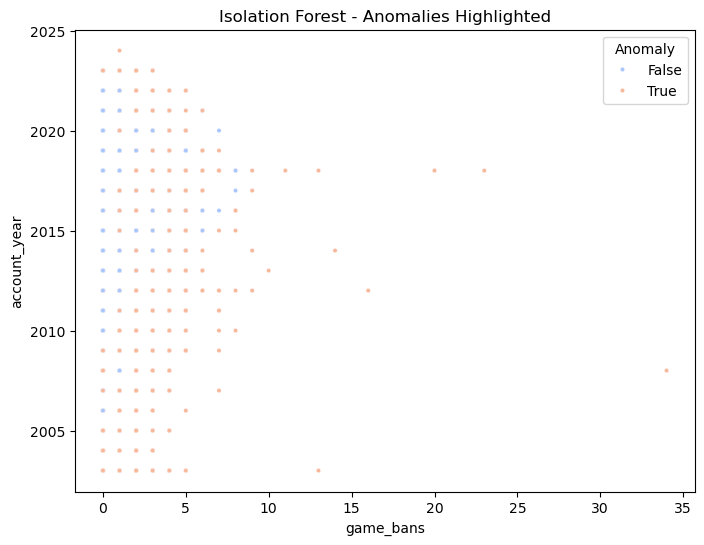

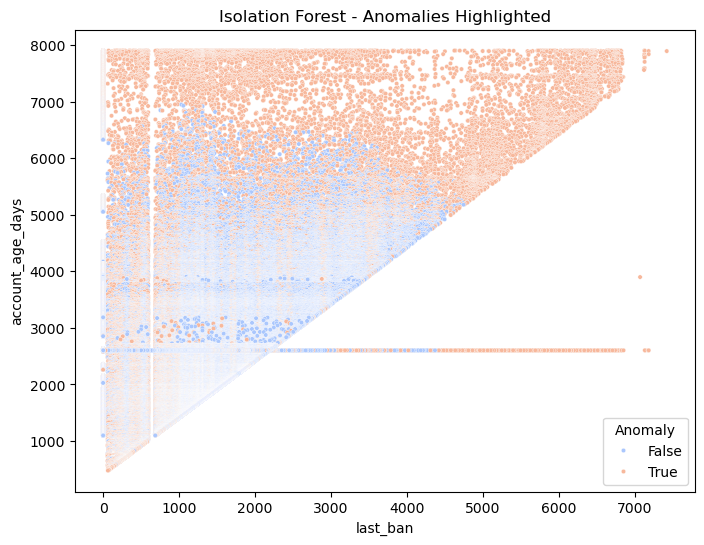

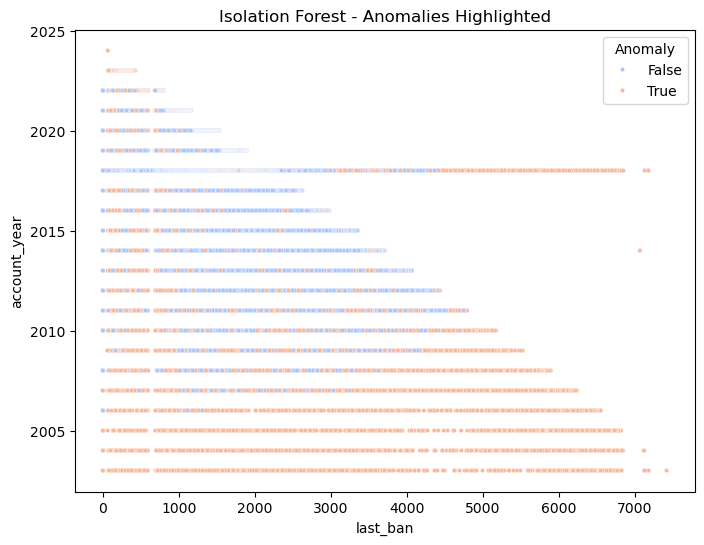

In [103]:
# Visualize Anomaly Flags on a Scatter Plot
for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=df_preprocessed_iso[columns_to_use[i]],
            y=df_preprocessed_iso[columns_to_use[j]],
            hue=df_preprocessed_iso['iso_anomaly'],
            palette='coolwarm',
            s=10
        )
        plt.title("Isolation Forest - Anomalies Highlighted")
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.legend(title="Anomaly")
        plt.show()

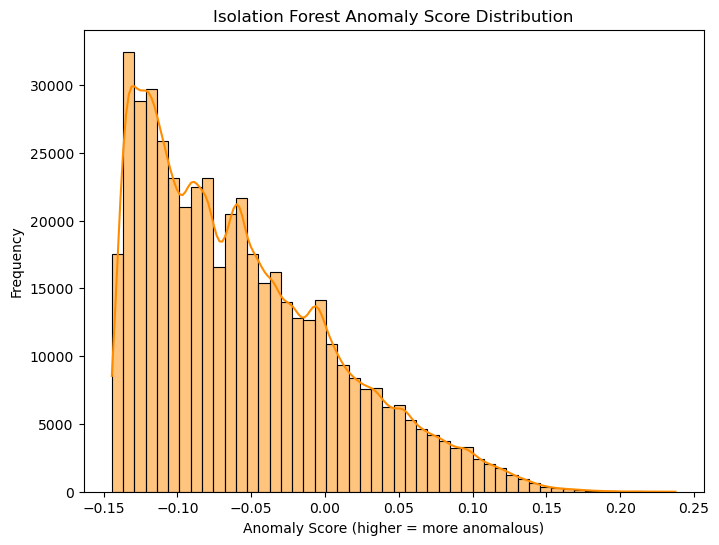

In [104]:
# Histogram of Anomaly Scores
plt.figure(figsize=(8, 6))
sns.histplot(df_preprocessed_iso['iso_score'], bins=50, kde=True, color='darkorange')
plt.title("Isolation Forest Anomaly Score Distribution")
plt.xlabel("Anomaly Score (higher = more anomalous)")
plt.ylabel("Frequency")
plt.show()

In [105]:
# Number of anomalies
num_anomalies = df_preprocessed_iso['iso_anomaly'].sum()
print(f"Number of anomalies detected (Isolation Forest): {num_anomalies}")

# Top 10 most anomalous rows
top_anomalies_iso = df_preprocessed_iso.sort_values('iso_score', ascending=False).head(10)
cols_to_display = ['iso_score', 'iso_anomaly'] + list(columns_to_use)
display(top_anomalies_iso[cols_to_display])

Number of anomalies detected (Isolation Forest): 92024


iso_score  iso_anomaly  communityvisibilitystate  vac_bans  game_bans  \
3124    0.237403         True                         3        15          2   
6468    0.232892         True                         3         2          0   
47      0.224736         True                         3         2          1   
15575   0.222882         True                         3         8          4   
5144    0.222789         True                         3         0          1   
2377    0.222069         True                         3         1          2   
12684   0.220718         True                         3         3          2   
20213   0.220401         True                         3         3          8   
3400    0.219408         True                         3         5          1   
27562   0.215870         True                         3        20          2   

       economy_ban  last_ban  steam_level  friends_count  game_count  \
3124             0     706.0     0.570077       0.547121    0.611321   
6468             0    3484.0     0.884197       0.839335    0.887334   
47               0    2476.0     0.554256       0.600461    0.546737   
15575            0      92.0     0.376836       0.255994    0.520526   
5144             0    2310.0     0.818906       0.789839    0.839978   
2377             0     188.0     0.657290       0.896629    0.743916   
12684            0    2343.0     0.328268       0.315454    0.321412   
20213            0    1132.0     0.503203       0.736985    0.530599   
3400             0     164.0     0.594399       0.802230    0.414762   
27562            0    2935.0     0.617938       0.566220    0.456121   

       total_playtime  cs2_playtime  account_age_days  account_year  \
3124         0.833658      0.754077              7814          2003   
6468         0.810788      0.471714              7465          2004   
47           0.812306      0.653086              7900          2003   
15575        0.789317      0.533427              6319          2008   
5144         0.934234      0.911228              7613          2004   
2377         0.905121      0.507827              7861          2003   
12684        0.704547      0.618834              6606          2007   
20213        0.803618      0.580073              5581          2010   
3400         0.750238      0.743153              7797          2003   
27562        0.779025      0.728844              5113          2011   

       game_count_missing  
3124                    0  
6468                    0  
47                      0  
15575                   0  
5144                    0  
2377                    0  
12684                   0  
20213                   0  
3400                    0  
27562                   0

### D2) One-Class SVM

In [109]:
# Create a fresh copy of the data
df_preprocessed_ocsvm = df_preprocessed.copy()

# Select features
X_ocsvm = df_preprocessed_ocsvm[columns_to_use]

# Initialize the One-Class SVM model
ocsvm = OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)

In [110]:
# Fit the One-Class SVM model
ocsvm.fit(X_ocsvm)

# Predict: -1 = anomaly, 1 = normal
ocsvm_preds = ocsvm.predict(X_ocsvm)

# Anomaly score: negative values = more anomalous
ocsvm_scores = ocsvm.decision_function(X_ocsvm)

# Add results to the DataFrame
df_preprocessed_ocsvm['ocsvm_anomaly'] = ocsvm_preds == -1
df_preprocessed_ocsvm['ocsvm_score'] = -ocsvm_scores  # Flip sign for consistency (higher = more anomalous)

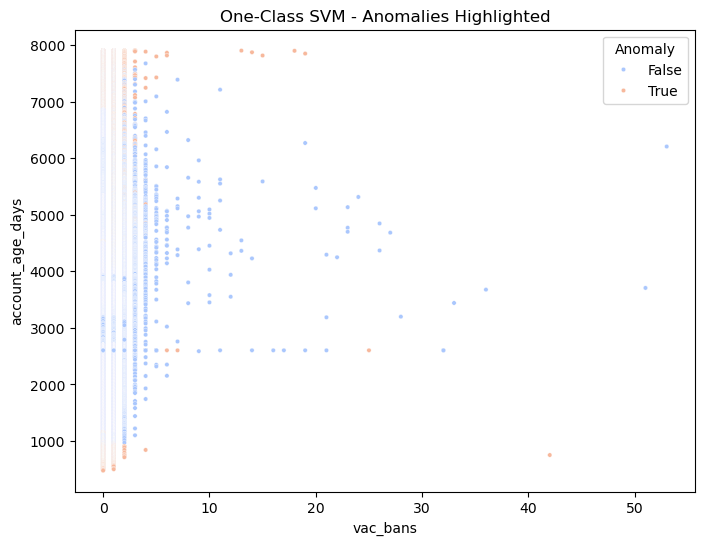

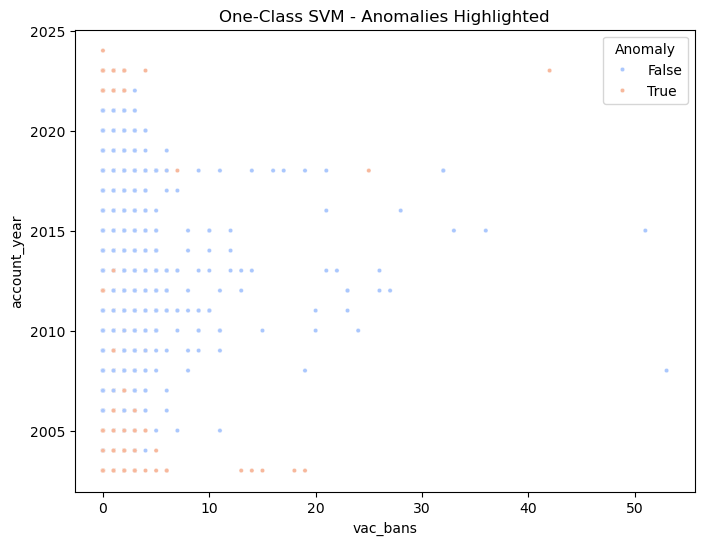

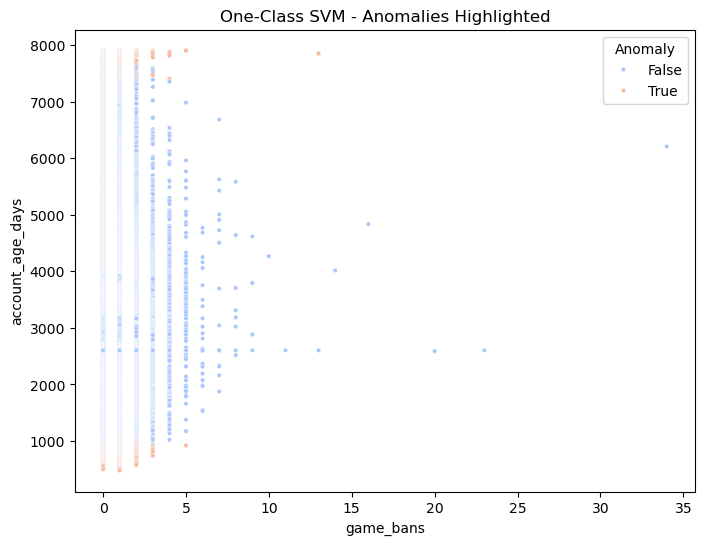

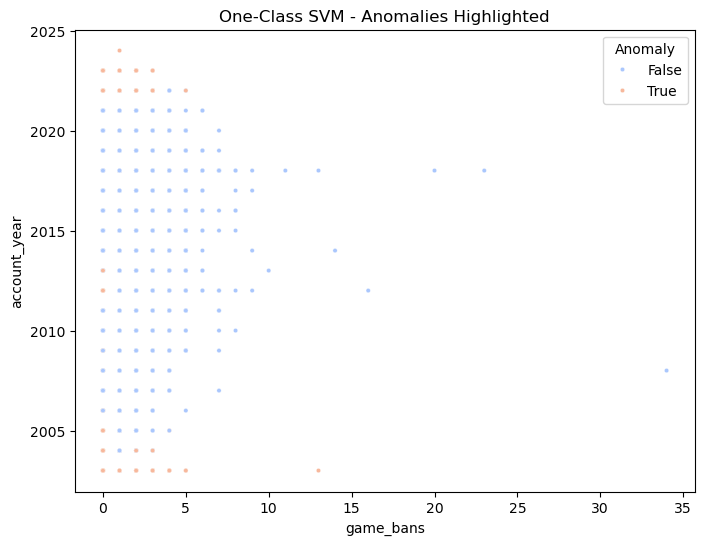

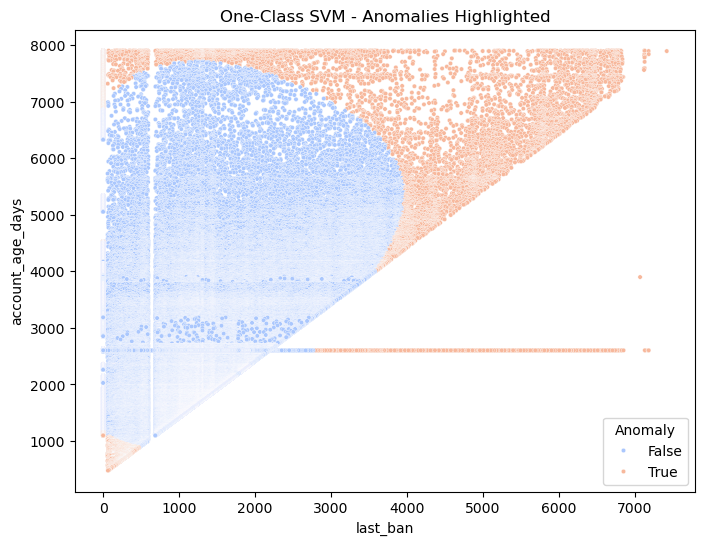

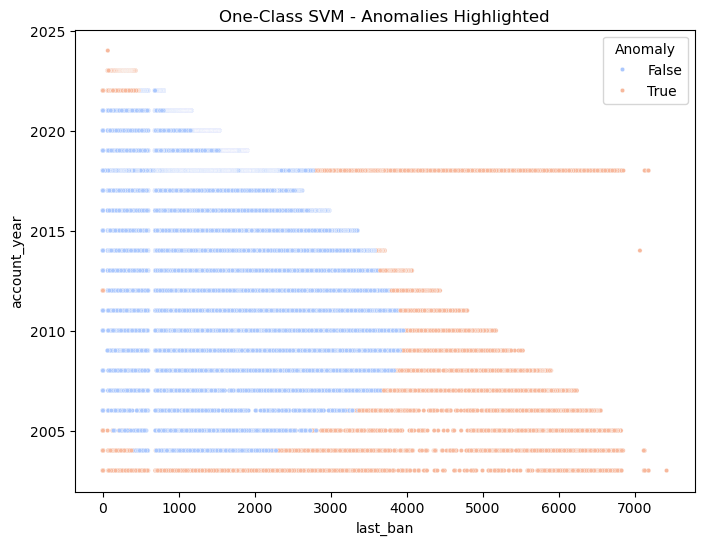

In [111]:
# Scatter Plot of Anomalies
for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=df_preprocessed_ocsvm[columns_to_use[i]],
            y=df_preprocessed_ocsvm[columns_to_use[j]],
            hue=df_preprocessed_ocsvm['ocsvm_anomaly'],
            palette='coolwarm',
            s=10
        )
        plt.title("One-Class SVM - Anomalies Highlighted")
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.legend(title="Anomaly")
        plt.show()

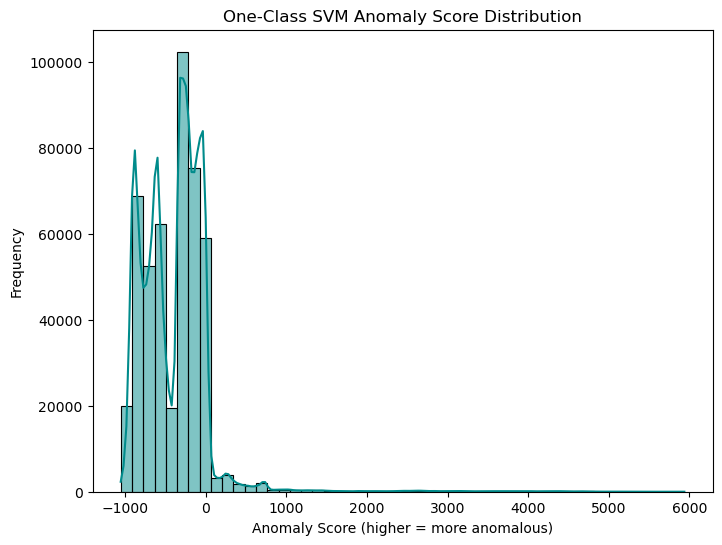

In [112]:
# Histogram of Anomaly Scores
plt.figure(figsize=(8, 6))
sns.histplot(df_preprocessed_ocsvm['ocsvm_score'], bins=50, kde=True, color='darkcyan')
plt.title("One-Class SVM Anomaly Score Distribution")
plt.xlabel("Anomaly Score (higher = more anomalous)")
plt.ylabel("Frequency")
plt.show()

In [113]:
# Number of anomalies detected
num_anomalies_ocsvm = df_preprocessed_ocsvm['ocsvm_anomaly'].sum()
print(f"Number of anomalies detected (One-Class SVM): {num_anomalies_ocsvm}")

# Top 10 anomalies
top_anomalies_ocsvm = df_preprocessed_ocsvm.sort_values('ocsvm_score', ascending=False).head(10)
cols_to_display = ['ocsvm_score', 'ocsvm_anomaly'] + list(columns_to_use)
display(top_anomalies_ocsvm[cols_to_display])

Number of anomalies detected (One-Class SVM): 23814


ocsvm_score  ocsvm_anomaly  communityvisibilitystate  vac_bans  \
5021  5936.954712           True                         2         1   
4543  5926.963923           True                         1         1   
1406  5876.758984           True                         2         1   
2881  5872.977060           True                         2         1   
1349  5535.576134           True                         3         1   
7532  5509.015230           True                         1         1   
7122  5477.086851           True                         1         1   
5790  5470.418994           True                         2         1   
2592  5453.059083           True                         1         1   
4735  5435.662782           True                         1         1   

      game_bans  economy_ban  last_ban  steam_level  friends_count  \
5021          0            0    7185.0     0.281205       0.459982   
4543          0            0    7177.0     0.281205       0.459982   
1406          0            0    7137.0     0.281205       0.459982   
2881          0            0    7134.0     0.281205       0.459982   
1349          0            0    7422.0     0.306888       0.412489   
7532          0            0    6853.0     0.281205       0.459982   
7122          0            0    6829.0     0.281205       0.459982   
5790          0            0    6824.0     0.281205       0.459982   
2592          0            0    6811.0     0.281205       0.459982   
4735          0            0    6798.0     0.281205       0.459982   

      game_count  total_playtime  cs2_playtime  account_age_days  \
5021    0.148759             0.0           0.0              2602   
4543    0.148759             0.0           0.0              2602   
1406    0.148759             0.0           0.0              2602   
2881    0.148759             0.0           0.0              2602   
1349    0.148759             0.0           0.0              7892   
7532    0.148759             0.0           0.0              2602   
7122    0.148759             0.0           0.0              2602   
5790    0.148759             0.0           0.0              2602   
2592    0.148759             0.0           0.0              2602   
4735    0.148759             0.0           0.0              2602   

      account_year  game_count_missing  
5021          2018                   1  
4543          2018                   1  
1406          2018                   1  
2881          2018                   1  
1349          2003                   1  
7532          2018                   1  
7122          2018                   1  
5790          2018                   1  
2592          2018                   1  
4735          2018                   1

### D3) Autoencoders

In [115]:
# Copy dataset
df_preprocessed_ae = df_preprocessed.copy()

# Feature matrix
X_ae = df_preprocessed_ae[columns_to_use].values.astype(np.float32)

In [116]:
# Input size = number of features
input_dim = X_ae.shape[1]

# Define the autoencoder architecture
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

# Define and compile the model
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
history = autoencoder.fit(
    X_ae, X_ae,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

Epoch 1/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 220973.8125 - val_loss: 4604.7251
Epoch 2/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 7.3755 - val_loss: 3997.9180
Epoch 3/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.9549 - val_loss: 3788.9763
Epoch 4/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.8323 - val_loss: 3681.0398
Epoch 5/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.7202 - val_loss: 3640.6243
Epoch 6/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.8104 - val_loss: 3645.9761
Epoch 7/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.3221 - val_loss: 3686.2295
Epoch 8/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 2.0764 - val_loss: 3622.5044
Epoch 9/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.8130 - val_loss: 3600.8035
Epoch 10/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.2093 - val_loss: 3588.3140
Epoch 11/20
1676/1676 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 1.4403 - val_loss: 35

In [117]:
# Get reconstructed output
X_ae_reconstructed = autoencoder.predict(X_ae)

# Compute Mean Squared Error (MSE) for each sample
reconstruction_error = np.mean(np.square(X_ae - X_ae_reconstructed), axis=1)

# Add error and anomaly flag to DataFrame
df_preprocessed_ae['ae_reconstruction_error'] = reconstruction_error

# Set threshold: 95th percentile of error (can adjust to be more/less strict)
threshold = np.percentile(reconstruction_error, 95)

# Flag anomalies
df_preprocessed_ae['ae_anomaly'] = df_preprocessed_ae['ae_reconstruction_error'] > threshold

14897/14897 ━━━━━━━━━━━━━━━━━━━━ 10s 640us/step


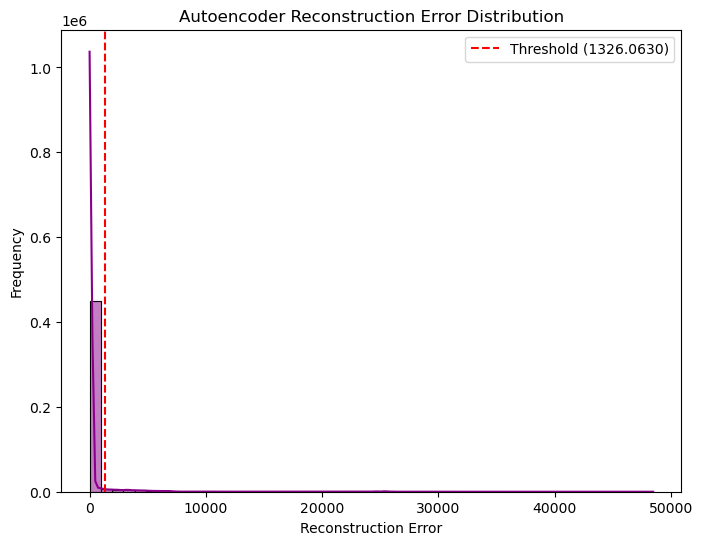

In [118]:
# Histogram of Reconstruction Errors
plt.figure(figsize=(8, 6))
sns.histplot(df_preprocessed_ae['ae_reconstruction_error'], bins=50, kde=True, color='darkmagenta')
plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold ({threshold:.4f})')
plt.title("Autoencoder Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

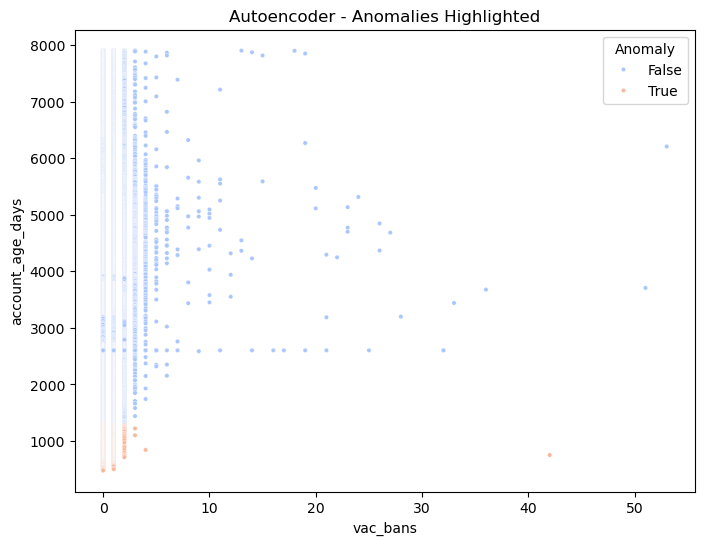

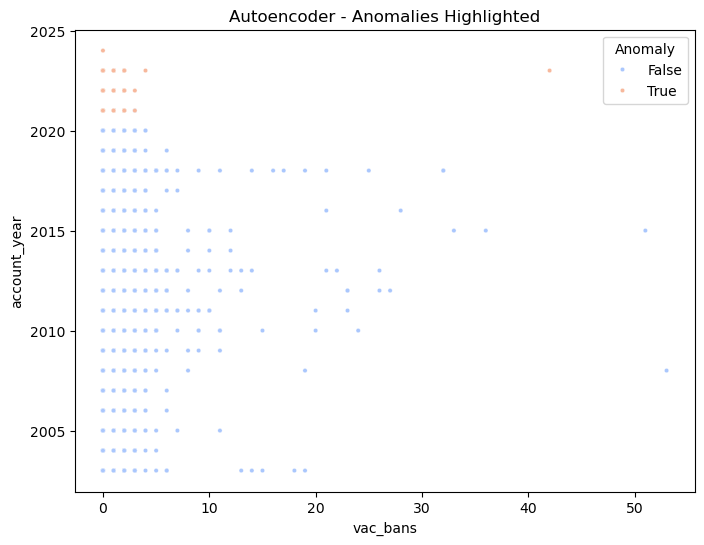

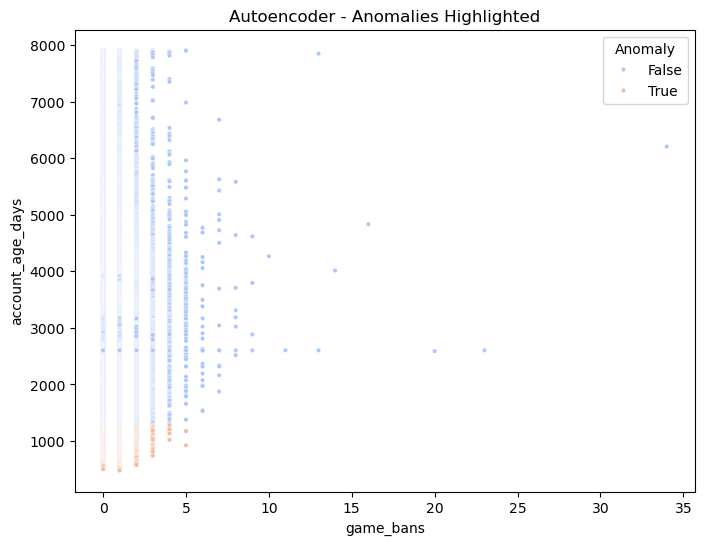

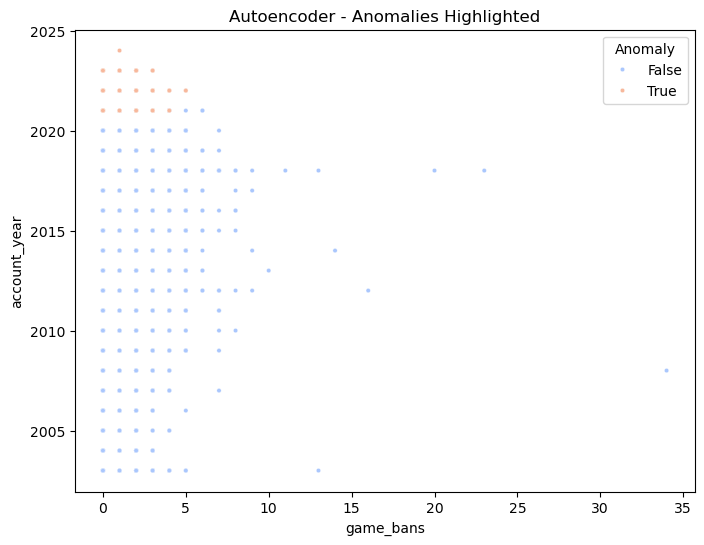

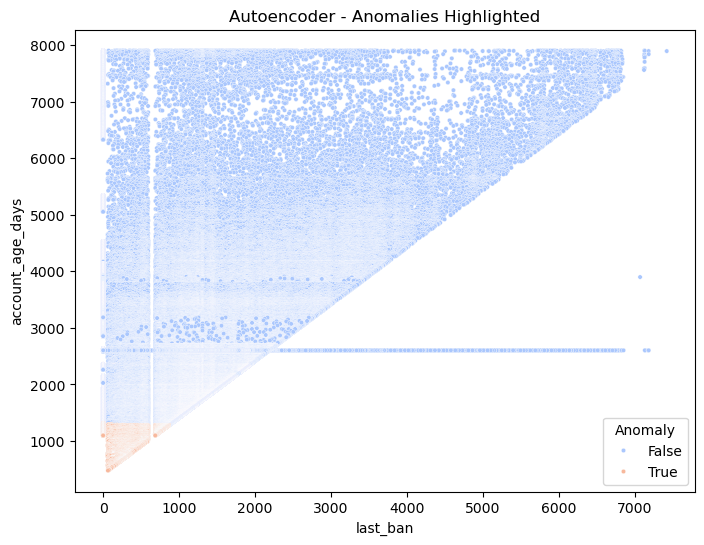

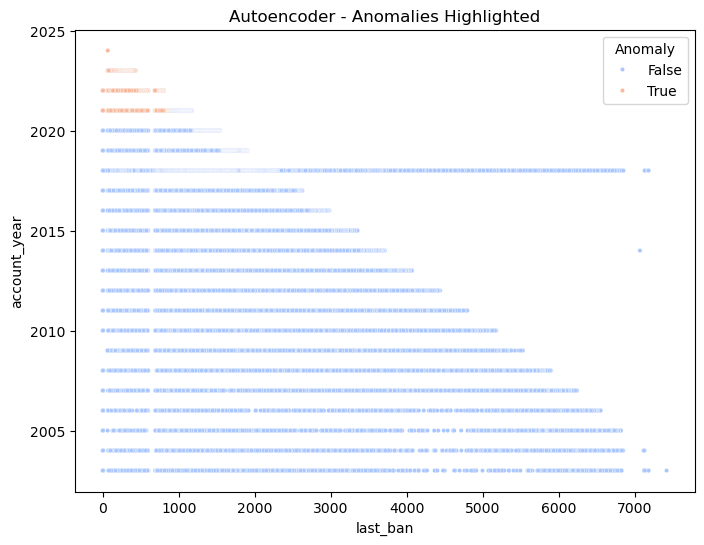

In [119]:
# Scatter Plot of Anomalies
for i in [1,2,4]:
    for j in [10,11]:
        plt.figure(figsize=(8, 6))
        sns.scatterplot(
            x=df_preprocessed_ae[columns_to_use[i]],
            y=df_preprocessed_ae[columns_to_use[j]],
            hue=df_preprocessed_ae['ae_anomaly'],
            palette='coolwarm',
            s=10
        )
        plt.title("Autoencoder - Anomalies Highlighted")
        plt.xlabel(columns_to_use[i])
        plt.ylabel(columns_to_use[j])
        plt.legend(title="Anomaly")
        plt.show()

In [120]:
# Number of anomalies detected
num_anomalies_ae = df_preprocessed_ae['ae_anomaly'].sum()
print(f"Number of anomalies detected (Autoencoder): {num_anomalies_ae}")

# Top 10 anomalies
top_anomalies_ae = df_preprocessed_ae.sort_values('ae_reconstruction_error', ascending=False).head(10)
cols_to_display = ['ae_reconstruction_error', 'ae_anomaly'] + list(columns_to_use)
display(top_anomalies_ae[cols_to_display])

Number of anomalies detected (Autoencoder): 23835


ae_reconstruction_error  ae_anomaly  communityvisibilitystate  \
476687             48481.179688        True                         3   
476680             47259.554688        True                         3   
476679             47208.871094        True                         3   
476678             47053.339844        True                         3   
476677             46855.789062        True                         3   
476676             46744.855469        True                         3   
476674             46458.648438        True                         3   
476672             46233.046875        True                         3   
476666             45973.042969        True                         3   
476662             45369.835938        True                         3   

        vac_bans  game_bans  economy_ban  last_ban  steam_level  \
476687         0          1            0      64.0      0.00000   
476680         0          1            0      76.0      0.00000   
476679         0          1            0      71.0      0.08871   
476678         0          1            0      78.0      0.00000   
476677         0          1            0      79.0      0.00000   
476676         0          1            0      81.0      0.00000   
476674         0          1            0      70.0      0.00000   
476672         0          1            0      86.0      0.00000   
476666         1          0            0      87.0      0.00000   
476662         0          1            0      66.0      0.08871   

        friends_count  game_count  total_playtime  cs2_playtime  \
476687       0.000000    0.148759             0.0           0.0   
476680       0.000000    0.148759             0.0           0.0   
476679       0.289055    0.148759             0.0           0.0   
476678       0.000000    0.148759             0.0           0.0   
476677       0.000000    0.148759             0.0           0.0   
476676       0.000000    0.148759             0.0           0.0   
476674       0.144528    0.148759             0.0           0.0   
476672       0.000000    0.148759             0.0           0.0   
476666       0.091187    0.148759             0.0           0.0   
476662       0.000000    0.148759             0.0           0.0   

        account_age_days  account_year  game_count_missing  
476687               476          2024                   1  
476680               487          2023                   1  
476679               488          2023                   1  
476678               489          2023                   1  
476677               491          2023                   1  
476676               492          2023                   1  
476674               496          2023                   1  
476672               497          2023                   1  
476666               500          2023                   1  
476662               508          2023                   1

# Step 8: Evaluation and Comparison

In [180]:
df_preprocessed_kmeans.columns

Index(['steam_id', 'profile_url', 'personaname', 'avatar',
       'communityvisibilitystate', 'vac_bans', 'game_bans', 'economy_ban',
       'last_ban', 'steam_level', 'friends_count', 'game_count',
       'total_playtime', 'cs2_playtime', 'account_age_days', 'account_year',
       'game_count_missing', 'cluster', 'anomaly', 'distance_to_cluster'],
      dtype='object')

In [215]:
df_preprocessed_kmeans.head()

steam_id                                        profile_url  \
0  76561197960265760  https://steamcommunity.com/profiles/7656119796...   
1  76561197960266640  https://steamcommunity.com/id/765611979602666420/   
2  76561197960267168              https://steamcommunity.com/id/c0R716/   
3  76561197960267328             https://steamcommunity.com/id/3digits/   
4  76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   

  personaname                                             avatar  \
0      Gordon  https://avatars.steamstatic.com/1eefc24823028f...   
1       Goose  https://avatars.steamstatic.com/5fb7d7eabf3add...   
2         c0R  https://avatars.steamstatic.com/9af72ff4737cf3...   
3       Fanik  https://avatars.steamstatic.com/8d43de6e684bc6...   
4  ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   

   communityvisibilitystate  vac_bans  game_bans  economy_ban  last_ban  \
0                         1         1          0            0    3401.0   
1                         3         1          1            0     183.0   
2                         2         2          0            0    3335.0   
3                         3         1          0            0    4639.0   
4                         3         0          0            0       0.0   

   steam_level  friends_count  game_count  total_playtime  cs2_playtime  \
0     0.281205       0.459982    0.148759        0.000000      0.000000   
1     0.281205       0.459982    0.148759        0.000000      0.000000   
2     0.281205       0.459982    0.148759        0.000000      0.000000   
3     0.318024       0.182374    0.148759        0.000000      0.000000   
4     0.337752       0.692331    0.170291        0.698667      0.780912   

   account_age_days  account_year  game_count_missing  cluster  anomaly  \
0              2602          2018                   1        4     True   
1              7901          2003                   1        2    False   
2              2602          2018                   1        1     True   
3              7901          2003                   1        4     True   
4              7901          2003                   0        2    False   

   distance_to_cluster  
0          1936.143566  
1           913.944392  
2          1897.080769  
3          3672.267342  
4          1004.006741

In [182]:
df_preprocessed_hdbscan.columns

Index(['steam_id', 'profile_url', 'personaname', 'avatar',
       'communityvisibilitystate', 'vac_bans', 'game_bans', 'economy_ban',
       'last_ban', 'steam_level', 'friends_count', 'game_count',
       'total_playtime', 'cs2_playtime', 'account_age_days', 'account_year',
       'game_count_missing', 'hdbscan_cluster', 'hdbscan_anomaly',
       'hdbscan_probability', 'is_noise', 'low_prob', 'hdbscan_anomaly_score'],
      dtype='object')

In [162]:
df_preprocessed_hdbscan.head()

steam_id                                        profile_url  \
0  76561197960265760  https://steamcommunity.com/profiles/7656119796...   
1  76561197960266640  https://steamcommunity.com/id/765611979602666420/   
2  76561197960267168              https://steamcommunity.com/id/c0R716/   
3  76561197960267328             https://steamcommunity.com/id/3digits/   
4  76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   

  personaname                                             avatar  \
0      Gordon  https://avatars.steamstatic.com/1eefc24823028f...   
1       Goose  https://avatars.steamstatic.com/5fb7d7eabf3add...   
2         c0R  https://avatars.steamstatic.com/9af72ff4737cf3...   
3       Fanik  https://avatars.steamstatic.com/8d43de6e684bc6...   
4  ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   

   communityvisibilitystate  vac_bans  game_bans  economy_ban  last_ban  \
0                         1         1          0            0    3401.0   
1                         3         1          1            0     183.0   
2                         2         2          0            0    3335.0   
3                         3         1          0            0    4639.0   
4                         3         0          0            0       0.0   

   steam_level  ...  cs2_playtime  account_age_days  account_year  \
0     0.281205  ...      0.000000              2602          2018   
1     0.281205  ...      0.000000              7901          2003   
2     0.281205  ...      0.000000              2602          2018   
3     0.318024  ...      0.000000              7901          2003   
4     0.337752  ...      0.780912              7901          2003   

   game_count_missing  hdbscan_cluster  hdbscan_anomaly  hdbscan_probability  \
0                   1             2376            False             1.000000   
1                   1              957            False             0.549561   
2                   1             2376            False             1.000000   
3                   1               -1             True             0.000000   
4                   0               -1             True             0.000000   

   is_noise  low_prob  hdbscan_anomaly_score  
0     False     False               0.000000  
1     False     False               0.450439  
2     False     False               0.000000  
3      True      True               1.000000  
4      True      True               1.000000  

[5 rows x 23 columns]

In [184]:
df_preprocessed_lof.columns

Index(['steam_id', 'profile_url', 'personaname', 'avatar',
       'communityvisibilitystate', 'vac_bans', 'game_bans', 'economy_ban',
       'last_ban', 'steam_level', 'friends_count', 'game_count',
       'total_playtime', 'cs2_playtime', 'account_age_days', 'account_year',
       'game_count_missing', 'lof_anomaly', 'lof_score'],
      dtype='object')

In [172]:
df_preprocessed_lof.head()

steam_id                                        profile_url  \
0  76561197960265760  https://steamcommunity.com/profiles/7656119796...   
1  76561197960266640  https://steamcommunity.com/id/765611979602666420/   
2  76561197960267168              https://steamcommunity.com/id/c0R716/   
3  76561197960267328             https://steamcommunity.com/id/3digits/   
4  76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   

  personaname                                             avatar  \
0      Gordon  https://avatars.steamstatic.com/1eefc24823028f...   
1       Goose  https://avatars.steamstatic.com/5fb7d7eabf3add...   
2         c0R  https://avatars.steamstatic.com/9af72ff4737cf3...   
3       Fanik  https://avatars.steamstatic.com/8d43de6e684bc6...   
4  ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   

   communityvisibilitystate  vac_bans  game_bans  economy_ban  last_ban  \
0                         1         1          0            0    3401.0   
1                         3         1          1            0     183.0   
2                         2         2          0            0    3335.0   
3                         3         1          0            0    4639.0   
4                         3         0          0            0       0.0   

   steam_level  friends_count  game_count  total_playtime  cs2_playtime  \
0     0.281205       0.459982    0.148759        0.000000      0.000000   
1     0.281205       0.459982    0.148759        0.000000      0.000000   
2     0.281205       0.459982    0.148759        0.000000      0.000000   
3     0.318024       0.182374    0.148759        0.000000      0.000000   
4     0.337752       0.692331    0.170291        0.698667      0.780912   

   account_age_days  account_year  game_count_missing  lof_anomaly  lof_score  
0              2602          2018                   1        False   1.040726  
1              7901          2003                   1        False   0.969131  
2              2602          2018                   1        False   1.013186  
3              7901          2003                   1        False   1.163189  
4              7901          2003                   0         True   7.150607

In [186]:
df_preprocessed_iso.columns

Index(['steam_id', 'profile_url', 'personaname', 'avatar',
       'communityvisibilitystate', 'vac_bans', 'game_bans', 'economy_ban',
       'last_ban', 'steam_level', 'friends_count', 'game_count',
       'total_playtime', 'cs2_playtime', 'account_age_days', 'account_year',
       'game_count_missing', 'iso_anomaly', 'iso_score', 'bin'],
      dtype='object')

In [174]:
df_preprocessed_iso.head()

steam_id                                        profile_url  \
0  76561197960265760  https://steamcommunity.com/profiles/7656119796...   
1  76561197960266640  https://steamcommunity.com/id/765611979602666420/   
2  76561197960267168              https://steamcommunity.com/id/c0R716/   
3  76561197960267328             https://steamcommunity.com/id/3digits/   
4  76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   

  personaname                                             avatar  \
0      Gordon  https://avatars.steamstatic.com/1eefc24823028f...   
1       Goose  https://avatars.steamstatic.com/5fb7d7eabf3add...   
2         c0R  https://avatars.steamstatic.com/9af72ff4737cf3...   
3       Fanik  https://avatars.steamstatic.com/8d43de6e684bc6...   
4  ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   

   communityvisibilitystate  vac_bans  game_bans  economy_ban  last_ban  \
0                         1         1          0            0    3401.0   
1                         3         1          1            0     183.0   
2                         2         2          0            0    3335.0   
3                         3         1          0            0    4639.0   
4                         3         0          0            0       0.0   

   steam_level  friends_count  game_count  total_playtime  cs2_playtime  \
0     0.281205       0.459982    0.148759        0.000000      0.000000   
1     0.281205       0.459982    0.148759        0.000000      0.000000   
2     0.281205       0.459982    0.148759        0.000000      0.000000   
3     0.318024       0.182374    0.148759        0.000000      0.000000   
4     0.337752       0.692331    0.170291        0.698667      0.780912   

   account_age_days  account_year  game_count_missing  iso_anomaly  iso_score  \
0              2602          2018                   1         True   0.008742   
1              7901          2003                   1         True   0.073757   
2              2602          2018                   1         True   0.043440   
3              7901          2003                   1         True   0.106746   
4              7901          2003                   0         True   0.101665   

               bin  
0   (0.438, 0.479]  
1   (0.438, 0.479]  
2   (0.438, 0.479]  
3  (-0.001, 0.289]  
4     (0.578, 1.0]

In [188]:
df_preprocessed_ocsvm.columns

Index(['steam_id', 'profile_url', 'personaname', 'avatar',
       'communityvisibilitystate', 'vac_bans', 'game_bans', 'economy_ban',
       'last_ban', 'steam_level', 'friends_count', 'game_count',
       'total_playtime', 'cs2_playtime', 'account_age_days', 'account_year',
       'game_count_missing', 'ocsvm_anomaly', 'ocsvm_score'],
      dtype='object')

In [176]:
df_preprocessed_ocsvm.head()

steam_id                                        profile_url  \
0  76561197960265760  https://steamcommunity.com/profiles/7656119796...   
1  76561197960266640  https://steamcommunity.com/id/765611979602666420/   
2  76561197960267168              https://steamcommunity.com/id/c0R716/   
3  76561197960267328             https://steamcommunity.com/id/3digits/   
4  76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   

  personaname                                             avatar  \
0      Gordon  https://avatars.steamstatic.com/1eefc24823028f...   
1       Goose  https://avatars.steamstatic.com/5fb7d7eabf3add...   
2         c0R  https://avatars.steamstatic.com/9af72ff4737cf3...   
3       Fanik  https://avatars.steamstatic.com/8d43de6e684bc6...   
4  ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   

   communityvisibilitystate  vac_bans  game_bans  economy_ban  last_ban  \
0                         1         1          0            0    3401.0   
1                         3         1          1            0     183.0   
2                         2         2          0            0    3335.0   
3                         3         1          0            0    4639.0   
4                         3         0          0            0       0.0   

   steam_level  friends_count  game_count  total_playtime  cs2_playtime  \
0     0.281205       0.459982    0.148759        0.000000      0.000000   
1     0.281205       0.459982    0.148759        0.000000      0.000000   
2     0.281205       0.459982    0.148759        0.000000      0.000000   
3     0.318024       0.182374    0.148759        0.000000      0.000000   
4     0.337752       0.692331    0.170291        0.698667      0.780912   

   account_age_days  account_year  game_count_missing  ocsvm_anomaly  \
0              2602          2018                   1           True   
1              7901          2003                   1           True   
2              2602          2018                   1           True   
3              7901          2003                   1           True   
4              7901          2003                   0           True   

   ocsvm_score  
0   669.083717  
1   589.762887  
2   591.031321  
3  2432.558860  
4   736.425475

In [190]:
df_preprocessed_ae.columns

Index(['steam_id', 'profile_url', 'personaname', 'avatar',
       'communityvisibilitystate', 'vac_bans', 'game_bans', 'economy_ban',
       'last_ban', 'steam_level', 'friends_count', 'game_count',
       'total_playtime', 'cs2_playtime', 'account_age_days', 'account_year',
       'game_count_missing', 'ae_reconstruction_error', 'ae_anomaly'],
      dtype='object')

In [178]:
df_preprocessed_ae.head()

steam_id                                        profile_url  \
0  76561197960265760  https://steamcommunity.com/profiles/7656119796...   
1  76561197960266640  https://steamcommunity.com/id/765611979602666420/   
2  76561197960267168              https://steamcommunity.com/id/c0R716/   
3  76561197960267328             https://steamcommunity.com/id/3digits/   
4  76561197960267408       https://steamcommunity.com/id/ErasusSwagboy/   

  personaname                                             avatar  \
0      Gordon  https://avatars.steamstatic.com/1eefc24823028f...   
1       Goose  https://avatars.steamstatic.com/5fb7d7eabf3add...   
2         c0R  https://avatars.steamstatic.com/9af72ff4737cf3...   
3       Fanik  https://avatars.steamstatic.com/8d43de6e684bc6...   
4  ShowS [NL]  https://avatars.steamstatic.com/76502ac8a395b6...   

   communityvisibilitystate  vac_bans  game_bans  economy_ban  last_ban  \
0                         1         1          0            0    3401.0   
1                         3         1          1            0     183.0   
2                         2         2          0            0    3335.0   
3                         3         1          0            0    4639.0   
4                         3         0          0            0       0.0   

   steam_level  friends_count  game_count  total_playtime  cs2_playtime  \
0     0.281205       0.459982    0.148759        0.000000      0.000000   
1     0.281205       0.459982    0.148759        0.000000      0.000000   
2     0.281205       0.459982    0.148759        0.000000      0.000000   
3     0.318024       0.182374    0.148759        0.000000      0.000000   
4     0.337752       0.692331    0.170291        0.698667      0.780912   

   account_age_days  account_year  game_count_missing  \
0              2602          2018                   1   
1              7901          2003                   1   
2              2602          2018                   1   
3              7901          2003                   1   
4              7901          2003                   0   

   ae_reconstruction_error  ae_anomaly  
0                 3.774063       False  
1                 1.964887       False  
2                 3.488052       False  
3                 5.634706       False  
4                 3.465857       False

In [216]:
# Step 1: Extract anomaly flags and reset index
df_kmeans = df_preprocessed_kmeans[['anomaly']].rename(columns={'anomaly': 'kmeans'})
df_hdbscan = df_preprocessed_hdbscan[['hdbscan_anomaly']].rename(columns={'hdbscan_anomaly': 'hdbscan'})
df_lof = df_preprocessed_lof[['lof_anomaly']].rename(columns={'lof_anomaly': 'lof'})
df_iso = df_preprocessed_iso[['iso_anomaly']].rename(columns={'iso_anomaly': 'iso'})
df_ocsvm = df_preprocessed_ocsvm[['ocsvm_anomaly']].rename(columns={'ocsvm_anomaly': 'ocsvm'})
df_ae = df_preprocessed_ae[['ae_anomaly']].rename(columns={'ae_anomaly': 'ae'})

# Step 2: Merge by index to preserve full row alignment
df_combined = pd.concat([df_kmeans, df_hdbscan, df_lof, df_iso, df_ocsvm, df_ae], axis=1)

# Step 3: Convert boolean to integer if needed
for col in ['kmeans', 'hdbscan', 'lof', 'iso', 'ocsvm', 'ae']:
    df_combined[col] = df_combined[col].astype(int)

# Step 4: Consensus score
df_combined['consensus_score'] = df_combined[['kmeans', 'hdbscan', 'lof', 'iso', 'ocsvm', 'ae']].sum(axis=1)

# Step 5: Define consensus set
consensus_threshold = 3
consensus_rows = df_combined[df_combined['consensus_score'] >= consensus_threshold]

# Step 6: Model comparison summary
comparison = []
for model in ['kmeans', 'hdbscan', 'lof', 'iso', 'ocsvm', 'ae']:
    total = df_combined[model].sum()
    overlap = consensus_rows[model].sum()
    overlap_percent = (overlap / total * 100) if total > 0 else 0
    comparison.append({
        'Model': model,
        'Total Anomalies': total,
        'Overlap with Consensus': overlap,
        'Overlap %': round(overlap_percent, 2)
    })

df_comparison = pd.DataFrame(comparison).sort_values(by='Overlap %', ascending=False)

# Display the result
print(df_comparison)

     Model  Total Anomalies  Overlap with Consensus  Overlap %
0   kmeans            15812                    8637      54.62
4    ocsvm            23814                   12164      51.08
5       ae            23835                    6187      25.96
3      iso            92024                   17606      19.13
2      lof            27550                    3820      13.87
1  hdbscan           152055                   12365       8.13
